In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import yfinance as yf
from tqdm.notebook import tqdm

# one-time download of nltk stopwords and wordnet resources required
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from scipy import sparse

#!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
# for google colab
# from google.colab import drive
# drive.mount('/content/drive')

# adjust as needed
# base_path = '/content/drive/My Drive/Colab Notebooks/'

In [2]:
# Let pandas handle date parsing internally — it's optimized and faster
news_df = pd.read_csv('analyst_ratings_processed.csv', parse_dates=['date']).dropna()
news_df['date'] = pd.to_datetime(news_df['date'], utc=True) # removed .dt.date
news_df['date'] = news_df['date'].dt.tz_localize(None) # new line of code to remove tz infor

prices_df = pd.read_csv('prices-split-adjusted.csv', parse_dates=['date']).dropna()
prices_df['date'] = pd.to_datetime(prices_df['date']) # changed to get pd.Timestamp

news_df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 14:30:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 14:45:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 08:30:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 16:45:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 15:38:00,A


In [3]:
# Clean column names
news_df = news_df.rename(columns={'title': 'headline', 'stock': 'ticker'})
prices_df = prices_df.rename(columns={'symbol': 'ticker'})

# Extract valid Fridays
friday_prices = prices_df[prices_df['date'].dt.dayofweek == 4][['ticker', 'date', 'close']].copy()
friday_prices = friday_prices.rename(columns={'date': 'friday_date', 'close': 'friday_close'})

# Create DataFrame of potential comparisons
friday_prices['monday'] = friday_prices['friday_date'] + pd.Timedelta(days=3)
friday_prices['tuesday'] = friday_prices['friday_date'] + pd.Timedelta(days=4)

# Get Monday open prices
monday_open = prices_df[['ticker', 'date', 'open']].copy()
monday_open = monday_open.rename(columns={'date': 'monday', 'open': 'monday_open'})

# Get Tuesday open prices
tuesday_open = prices_df[['ticker', 'date', 'open']].copy()
tuesday_open = tuesday_open.rename(columns={'date': 'tuesday', 'open': 'tuesday_open'})

# Merge to attach possible Monday and Tuesday open prices
merged = pd.merge(friday_prices, monday_open, on=['ticker', 'monday'], how='left')
merged = pd.merge(merged, tuesday_open, on=['ticker', 'tuesday'], how='left')

# Use Monday open if it exists, otherwise fallback to Tuesday open
merged['next_open'] = merged['monday_open'].combine_first(merged['tuesday_open'])

# If both Monday and Tuesday are missing (market closed 2 days), drop the row
merged = merged.dropna(subset=['next_open', 'friday_close'])

# create target variable: 'UP' if Monday's open is higher than Friday's close, 'DOWN' otherwise
merged['target'] = np.where(merged['next_open'] > merged['friday_close'], 'UP', 'DOWN')

# keep track of Monday or Tuesday opens
merged['open_day'] = np.where(
    ~merged['monday_open'].isna(), 'Monday',
    np.where(~merged['tuesday_open'].isna(), 'Tuesday', 'Missing')
)

merged.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day
0,WLTW,2016-01-08,116.620003,2016-01-11,2016-01-12,117.010002,115.510002,117.010002,UP,Monday
1,WLTW,2016-01-15,112.529999,2016-01-18,2016-01-19,NaN,113.660004,113.660004,UP,Tuesday
2,WLTW,2016-01-22,111.949997,2016-01-25,2016-01-26,111.320000,110.419998,111.320000,DOWN,Monday
3,WLTW,2016-01-29,114.470001,2016-02-01,2016-02-02,114.000000,113.250000,114.000000,DOWN,Monday
4,WLTW,2016-02-05,114.019997,2016-02-08,2016-02-09,113.300003,111.169998,113.300003,DOWN,Monday


In [4]:
# track time required to list weekly headlines
start = time.time()

# ensure news_df converted to datetime
news_df['date'] = pd.to_datetime(news_df['date'])

# determine actual open date used
merged['open_date_used'] = merged['monday']
merged.loc[merged['monday_open'].isna(), 'open_date_used'] = merged['tuesday']
merged['open_date_used'] = pd.to_datetime(merged['open_date_used'])

# create start and end date ranges
merged['start_date'] = merged['open_date_used'] - pd.Timedelta(days=7)
merged['end_date'] = merged['open_date_used'] - pd.Timedelta(days=1)

# reset index to track original rows
merged = merged.reset_index().rename(columns={'index': 'orig_index'})

# join on ticker to create expanded set of candidate news rows
news_expanded = pd.merge(
    merged[['orig_index', 'ticker', 'start_date', 'end_date']],
    news_df[['ticker', 'date', 'headline']],
    on='ticker',
    how='left'
)

# filter news within the 7-day window
mask = (news_expanded['date'] >= news_expanded['start_date']) & \
       (news_expanded['date'] <= news_expanded['end_date'])
news_expanded = news_expanded[mask]

# aggregate headlines by row
headline_agg = news_expanded.groupby('orig_index')['headline'] \
    .apply(lambda x: " ".join(x)).reset_index()

# merge aggregated headlines back into merged
merged = pd.merge(merged, headline_agg, on='orig_index', how='left')
merged = merged.rename(columns={'headline': 'weekly_headlines'})

# drop empty headline rows
merged = merged[merged['weekly_headlines'].str.strip().notna()]

# clean temp columns
merged.drop(columns=['start_date', 'end_date', 'orig_index'], inplace=True)

headline_list_time = time.time() - start
print('Time required to build weekly headline lists (sec): {:.1f}'.format(headline_list_time))

Time required to build weekly headline lists (sec): 44.8


In [14]:
# merged.to_csv("merged_with_weekly_headlines.csv", index=False)

In [5]:
# pre-process text information

# Setup
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Cleaning function
def clean(doc):
    # Lowercase and remove stopwords
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # Remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # Lemmatize words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Apply to 'weekly_headlines' column
merged['weekly_headlines_clean'] = merged['weekly_headlines'].apply(clean)

In [6]:
# make sure merged has a clean, sequential index
merged = merged.reset_index(drop=True)
merged.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day,open_date_used,weekly_headlines,weekly_headlines_clean
0,AAP,2010-01-08,40.639999,2010-01-11,2010-01-12,40.720001,39.430000,40.720001,UP,Monday,2010-01-11,Advance Auto Parts – A Turnaround Candidate (AAP),advance auto part – turnaround candidate aap
1,ABC,2010-01-08,26.049999,2010-01-11,2010-01-12,26.240000,26.320000,26.240000,UP,Monday,2010-01-11,"Benzinga’s Top Downgrades (WEN, CMP, ACL, PPDI...",benzinga’s top downgrade wen cmp acl ppdi abc
2,ACN,2010-01-08,42.570000,2010-01-11,2010-01-12,42.439999,42.209999,42.439999,DOWN,Monday,2010-01-11,Economic Effects Of Tiger’s Misses! Is There A...,economic effect tiger’s miss sex tape tiger wo...
3,ADBE,2010-01-08,36.689999,2010-01-11,2010-01-12,36.680000,36.139999,36.680000,DOWN,Monday,2010-01-11,Silicon Valley Reeling Under High Vacancy Rate...,silicon valley reeling high vacancy rate cbg a...
4,AET,2010-01-08,32.700001,2010-01-11,2010-01-12,32.770000,32.630001,32.770000,UP,Monday,2010-01-11,Positive Outlook And Better Guidance Results I...,positive outlook better guidance result upgrad...


In [366]:
# vectorize cleaned weekly headlines
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=5000)  # Limit features for memory
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])

Vectorizing text...


In [367]:
# train randomforest classifier and measure train time
start = time.time()

X = X_text
y = merged['target']

# Save original indices
original_indices = merged.index

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42)

print("Training model...")
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Training model...
Time required to train model (sec): 295.9


In [368]:
y_pred = clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      DOWN    UP
DOWN  3960  2756
UP    2945  3751

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.57      0.59      0.58      6716
          UP       0.58      0.56      0.57      6696

    accuracy                           0.57     13412
   macro avg       0.57      0.57      0.57     13412
weighted avg       0.57      0.57      0.57     13412



In [372]:
# get predicted probabilities of going 'UP'
y_proba = clf.predict_proba(X_test)
proba_up = y_proba[:, 1]

# create dataframe to assess top predictions
results = pd.DataFrame({
    'ticker': merged.loc[test_idx, 'ticker'].values,
    'prob_up': proba_up,
    'true_label': y_test,
    'headline': merged.loc[test_idx, 'weekly_headlines_clean'].values
})

# find top 20 most confident predictions for 'UP'
top_20_up = results.sort_values('prob_up', ascending=False).head(20)
print(top_20_up[['ticker', 'true_label', 'prob_up', 'headline']])

      ticker true_label  prob_up  \
49572    MPC         UP    1.000   
7821    URBN       DOWN    0.998   
1536     ETR         UP    0.998   
9234    ATVI       DOWN    0.998   
41418    MAR         UP    0.996   
1590    PBCT         UP    0.996   
40607      L         UP    0.994   
40640    NOV       DOWN    0.994   
10610      D         UP    0.992   
30626     MO         UP    0.992   
56467     CA         UP    0.992   
10598    CMS         UP    0.992   
43496   SPLS       DOWN    0.992   
30584   GRMN         UP    0.992   
41032    KSS         UP    0.992   
1900    BBBY       DOWN    0.990   
52242    AMP         UP    0.988   
10648    HCN         UP    0.984   
37742    LNC         UP    0.982   
21273    ITW         UP    0.982   

                                                headline  
49572  oppenheimer 3 healthcare stock 2 energy stock buy  
7821                          market rangebound 11302010  
1536       investor need pay attention dividend etf 2010  
9234   

In [373]:
# Find top 10 likeliest stocks to go up in a given week
# Step 1: set target week
target_open_date = pd.to_datetime("2016-09-19")
week_data = merged[merged['open_date_used'] == target_open_date]

# Step 2: Get the subset of test data from merged that matches this latest date
# Filter merged rows that are both in the test set and match the latest date
target_open_mask = (merged['open_date_used'] == target_open_date)
target_open_test_mask = target_open_mask & merged.index.isin(test_idx)

# Step 3: Get the indices for these filtered rows
target_open_test_indices = merged[target_open_test_mask].index

# Safety check
print(f"Number of test rows from the selected week: {len(target_open_test_indices)}")

Number of test rows from the selected week: 32


In [374]:
# Step 4: Get positional indices within X_test
position_in_test = [i for i, idx in enumerate(test_idx) if idx in target_open_test_indices]

# Step 5: Subset X_test and get predicted probabilities
X_test_latest = X_test[position_in_test]
y_prob_latest = clf.predict_proba(X_test_latest)
up_probabilities_latest = y_prob_latest[:, 1]

# Step 6: Prepare the merged DataFrame slice for matching rows
merged_latest_test = merged.loc[test_idx].iloc[position_in_test]

# Step 7: Create results DataFrame and display top 10 'UP' predictions
results_latest = pd.DataFrame({
    'ticker': merged_latest_test['ticker'].values,
    'prob_up': up_probabilities_latest,
    'true_label': y_test.iloc[position_in_test].values,
    'headline': merged_latest_test['weekly_headlines_clean'].values
})

top_10_up = results_latest.sort_values('prob_up', ascending=False).head(10)
print('For open date of: ', target_open_date)
print(top_10_up[['ticker', 'prob_up', 'headline']])

For open date of:  2016-09-19 00:00:00
   ticker   prob_up                                           headline
20     EW  0.945389               cramers 11 stock buy fedfear selloff
18    IVZ  0.742911            invesco report aug 31st aum 11 mom 821b
30    EOG  0.676000  fbr capital initiate coverage eog resource out...
28    ADS  0.663000  alliance data report 23 increase yoy receivabl...
26    ALL  0.631267     allstate report catastrophe loss aug 2016 154m
14    KSU  0.614000  morgan stanley share highlight freight confere...
2     OXY  0.585564  benzingas top downgrade jp morgan downgrade oc...
22    MYL  0.584702  house oversight committee hold sept 21 hearing...
16    NRG  0.562000  watch 7 huge call purchase thursday trade opti...
19     XL  0.559832  benzingas top downgrade janney capital downgra...


In [375]:
# model performance

# find previous friday close and monday open prices for target open date
friday_before = target_open_date - timedelta(days=3)
tickers_of_interest = top_10_up['ticker'].unique()

friday_prices = prices_df[
    (prices_df['ticker'].isin(tickers_of_interest)) &
    (prices_df['date'] == friday_before)
][['ticker', 'close']].rename(columns={'close': 'friday_close'})

monday_open_prices = prices_df[
    (prices_df['ticker'].isin(tickers_of_interest)) &
    (prices_df['date'] == target_open_date)
][['ticker', 'open']].rename(columns={'open': 'monday_open'})

# merge both prices into top_10_up
top_10_enriched = top_10_up.merge(friday_prices, on='ticker', how='left')
top_10_enriched = top_10_enriched.merge(monday_open_prices, on='ticker', how='left')

# 8. Compute the price change (absolute and percentage)
top_10_enriched['price_change'] = top_10_enriched['monday_open'] - top_10_enriched['friday_close']
top_10_enriched['pct_change'] = (top_10_enriched['price_change'] / top_10_enriched['friday_close']) * 100

# 9. Display the final result
print(top_10_enriched[['ticker', 'prob_up', 'friday_close', 'monday_open', 'price_change', 'pct_change', 'headline']])

  ticker   prob_up  friday_close  monday_open  price_change  pct_change  \
0     EW  0.945389    116.599998   116.620003      0.020005    0.017157   
1    IVZ  0.742911     30.180000    30.400000      0.220000    0.728960   
2    EOG  0.676000     90.970001    91.660004      0.690003    0.758495   
3    ADS  0.663000    214.479996   215.759995      1.279999    0.596792   
4    ALL  0.631267     67.410004    67.580002      0.169998    0.252185   
5    KSU  0.614000     91.070000    91.760002      0.690002    0.757661   
6    OXY  0.585564     71.029999    71.529999      0.500000    0.703928   
7    MYL  0.584702     41.790001    41.970001      0.180000    0.430725   
8    NRG  0.562000     11.260000    11.270000      0.010000    0.088810   
9     XL  0.559832     33.450001    33.540001      0.090000    0.269058   

                                            headline  
0               cramers 11 stock buy fedfear selloff  
1            invesco report aug 31st aum 11 mom 821b  
2  fbr ca

## Including Weekly Volatility

In [15]:
# compute daily returns
prices_df.sort_values(by=['ticker', 'date'], inplace=True)
prices_df['daily_return'] = prices_df.groupby('ticker')['close'].pct_change()

In [17]:
# add week of column to allow grouping by ticker and week
prices_df['week'] = prices_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

In [22]:
# compute weekly volatility
weekly_volatility = prices_df.groupby(['ticker', 'week'])['daily_return'].std().reset_index()
weekly_volatility.rename(columns={'daily_return': 'weekly_volatility'}, inplace=True)

# lag weekly volatility to use the previous week's volatility
weekly_volatility['previous_week'] = weekly_volatility.groupby('ticker')['weekly_volatility'].shift(1)

In [25]:
# merge weekly volatility into previously merged data
merged['week'] = merged['monday'].dt.to_period('W').apply(lambda r: r.start_time)
merged = pd.merge(merged, weekly_volatility[['ticker', 'week', 'previous_week']], 
                  on=['ticker', 'week'], how='left')

In [28]:
# standardize volatility
# Drop rows with missing volatility
merged_model = merged.dropna(subset=['previous_week']).copy()

# Create a scaler
scaler = StandardScaler()

# Fit and transform the 'previous_week' column
merged_model['volatility_scaled'] = scaler.fit_transform(
    merged_model[['previous_week']]
)

In [31]:
# concatenate TF-IDF matrix with volatility feature
X_text = tfidf.fit_transform(merged_model['weekly_headlines_clean'])

volatility_sparse = sparse.csr_matrix(
    merged_model['volatility_scaled'].values.reshape(-1, 1)
)

# Combine text features and volatility
X = hstack([X_text, volatility_sparse])
y = merged_model['target']

In [35]:
# initialize and train the classifier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

svm_clf = SVC(kernel='linear')

# Train model
print("Training model...")
start = time.time()
svm_clf.fit(X_train, y_train)
train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Training model...
Time required to train model (sec): 282.9


In [36]:
y_pred = svm_clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      DOWN    UP
DOWN  3884  2840
UP    3303  3384

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.54      0.58      0.56      6724
          UP       0.54      0.51      0.52      6687

    accuracy                           0.54     13411
   macro avg       0.54      0.54      0.54     13411
weighted avg       0.54      0.54      0.54     13411



In [44]:
# try xgboost
y = merged_model['target'].map({'DOWN': 0, 'UP': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

start = time.time()

# Define model
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_clf.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Time required to train model (sec): 2.9


In [45]:
y_pred = xgb_clf.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      0     1
0  4527  2197
1  4008  2679

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59      6724
           1       0.55      0.40      0.46      6687

    accuracy                           0.54     13411
   macro avg       0.54      0.54      0.53     13411
weighted avg       0.54      0.54      0.53     13411



In [46]:
vectorizer_full = TfidfVectorizer()
vectorizer_full.fit(merged['weekly_headlines_clean'])
print("Full vocabulary size:", len(vectorizer_full.vocabulary_))

Full vocabulary size: 57105


In [49]:
from sklearn.metrics import accuracy_score

for max_feat in [500, 1000, 5000, None]:
    start = time.time()
    
    tfidf = TfidfVectorizer(max_features=max_feat)
    X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
    y = merged['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    train_time = time.time() - start
    print(f"max_features={max_feat}, Accuracy={score:.4f}, Train time={train_time:.2f}")

max_features=500, Accuracy=0.5576, Train time=49.48
max_features=1000, Accuracy=0.5650, Train time=52.80
max_features=5000, Accuracy=0.5720, Train time=60.82
max_features=None, Accuracy=0.5720, Train time=357.87


In [51]:
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

for n in [100, 200, 500, 1000]:
    start = time.time()
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    train_time = time.time() - start
    print(f"n_estimators: {n} | Accuracy: {acc:.4f} | Train time: {train_time:.2f}")

n_estimators: 100 | Accuracy: 0.5720 | Train time: 62.13
n_estimators: 200 | Accuracy: 0.5742 | Train time: 123.55
n_estimators: 500 | Accuracy: 0.5749 | Train time: 316.46
n_estimators: 1000 | Accuracy: 0.5771 | Train time: 647.61


In [53]:
from sklearn.linear_model import LogisticRegression

start = time.time()

# Initialize model
log_reg = LogisticRegression(max_iter=2000, random_state=42)

# Fit model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

train_time = time.time() - start

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f} |Train time: {train_time:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5463 |Train time: 0.18

Confusion Matrix:
 [[3690 3026]
 [3059 3637]]
Classification Report:
               precision    recall  f1-score   support

        DOWN       0.55      0.55      0.55      6716
          UP       0.55      0.54      0.54      6696

    accuracy                           0.55     13412
   macro avg       0.55      0.55      0.55     13412
weighted avg       0.55      0.55      0.55     13412



## Neural Network

In [248]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [199]:
# Build model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(128,activation='relu'),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [201]:
tfidf = TfidfVectorizer(max_features=5000)
X_text = tfidf.fit_transform(merged['weekly_headlines_clean'])
y = merged['target'].map({'DOWN': 0, 'UP': 1})  # Ensure numeric target

X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

X_train_dense = X_train.toarray().astype('float32')
X_test_dense = X_test.toarray().astype('float32')

start = time.time()

# Train model
history = model.fit(
    X_train.toarray(), y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Predict and evaluate
y_pred_nn = (model.predict(X_test.toarray()) > 0.5).astype("int32")
acc = accuracy_score(y_test, y_pred_nn)

train_time = time.time() - start

print(f"Accuracy: {acc:.4f} |Train time: {train_time:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5106 - loss: 0.6926 - val_accuracy: 0.5391 - val_loss: 0.6887
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5933 - loss: 0.6735 - val_accuracy: 0.5505 - val_loss: 0.6857
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6379 - loss: 0.6386 - val_accuracy: 0.5553 - val_loss: 0.6942
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6879 - loss: 0.5940 - val_accuracy: 0.5526 - val_loss: 0.7163
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7261 - loss: 0.5472 - val_accuracy: 0.5559 - val_loss: 0.7385
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7726 - loss: 0.4843 - val_accuracy: 0.5569 - val_loss: 0.7731
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8058 - loss: 0.4304 - val_accuracy: 0.5538 - val_loss: 0.8067
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8307 - loss: 0.3812 - val_accuracy: 0.

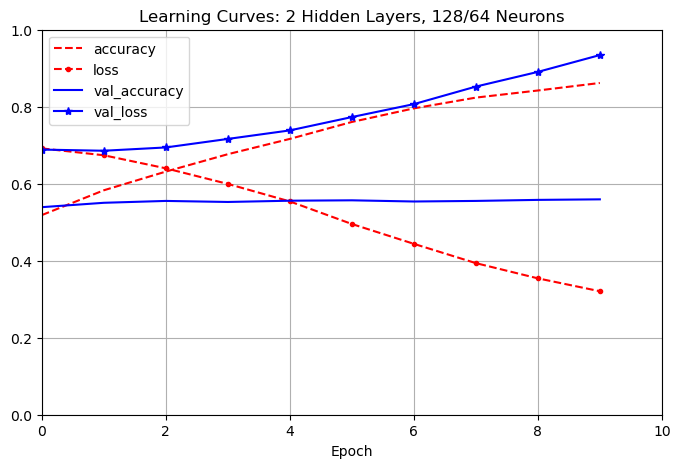

In [202]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0, 10], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--.', 'b-', 'b-*'])
plt.title('Learning Curves: 2 Hidden Layers, 128/64 Neurons')
plt.show()

In [346]:
# Compute 52-week moving average and percent undervalued/overvalued

# Drop any existing 'valuation_feature' column from merged
if 'valuation_feature' in merged.columns:
    merged = merged.drop(columns=['valuation_feature'])

# 52-week (approx. 252 trading days) moving average
prices_df['52wk_ma'] = prices_df.groupby('ticker')['close'].transform(
    lambda x: x.rolling(window=252, min_periods=252).mean()
)

# Create new feature: percent_diff_from_52wk_avg = (close - 52wk_ma) / 52wk_ma
prices_df['percent_from_52wk_avg'] = (
    (prices_df['close'] - prices_df['52wk_ma']) / prices_df['52wk_ma']
)

# Get previous Friday's close for each open_date_used
merged['prev_friday'] = pd.to_datetime(merged['open_date_used']) - pd.to_timedelta(
    pd.to_datetime(merged['open_date_used']).dt.weekday + 3, unit='D'
)

# merge percent valuation feature into merged
merged = merged.merge(
    prices_df[['ticker', 'date', 'percent_from_52wk_avg']],
    left_on=['ticker', 'prev_friday'],
    right_on=['ticker', 'date'],
    how='left'
)

# Clean up merged dataframe
merged = merged.rename(columns={'percent_from_52wk_avg': 'valuation_feature'})
merged.drop(columns=['date'], inplace=True)

In [252]:
# step 1: prepare inputs

# Filter rows with non-null headlines and valuation features
nn_data = merged.dropna(subset=['weekly_headlines_clean', 'valuation_feature', 'target'])

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(nn_data['weekly_headlines_clean'])
sequences = tokenizer.texts_to_sequences(nn_data['weekly_headlines_clean'])
padded_headlines = pad_sequences(sequences, maxlen=30, padding='post')

# Normalize valuation feature
valuation_input = nn_data['valuation_feature'].values.reshape(-1, 1)

# Target variable: 1 if stock went up, else 0
labels = nn_data['target'].map({'DOWN': 0, 'UP': 1}).values

In [253]:
# step 2: train/test split
X_text_train, X_text_test, X_val_train, X_val_test, y_train, y_test = train_test_split(
    padded_headlines, valuation_input, labels, test_size=0.2, random_state=42
)

In [255]:
# step 3: build the model

# text input
text_input = Input(shape=(30,), name='text_input')
x = Embedding(input_dim=10000, output_dim=16)(text_input)
x = GlobalAveragePooling1D()(x)

# numeric input
val_input = Input(shape=(1,), name='valuation_input')

# combine
combined = Concatenate()([x, val_input])
dense = Dense(16, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense)


model = Model(inputs=[text_input, val_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [256]:
# step 4: train the model
history = model.fit(
    {'text_input': X_text_train, 'valuation_input': X_val_train},
    y_train,
    validation_data=({'text_input': X_text_test, 'valuation_input': X_val_test}, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - accuracy: 0.5112 - loss: 0.6929 - val_accuracy: 0.5384 - val_loss: 0.6899
Epoch 2/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.5703 - loss: 0.6799 - val_accuracy: 0.5445 - val_loss: 0.6889
Epoch 3/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - accuracy: 0.6169 - loss: 0.6464 - val_accuracy: 0.5535 - val_loss: 0.6983
Epoch 4/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.6511 - loss: 0.6167 - val_accuracy: 0.5524 - val_loss: 0.7144
Epoch 5/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.6723 - loss: 0.5915 - val_accuracy: 0.5490 - val_loss: 0.7304
Epoch 6/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.6915 - loss: 0.5677 - val_accuracy: 0.5557 - val_loss: 0.7413
Epoch 7/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.7142 - loss: 0.5409 - val_accuracy: 0.5513 - val_loss: 0.7688
Epoch 8/10
1458/1458 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.7295 -

In [260]:
# Predict using the trained model
y_pred_nn = (model.predict({'text_input': X_text_test, 'valuation_input': X_val_test}) > 0.5).astype("int32")

# Calculate accuracy
acc = accuracy_score(y_test, y_pred_nn)

print(f"Accuracy: {acc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Classification Report:\n", classification_report(y_test, y_pred_nn))

365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
Accuracy: 0.5500

Confusion Matrix:
 [[3906 2234]
 [3013 2507]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.64      0.60      6140
           1       0.53      0.45      0.49      5520

    accuracy                           0.55     11660
   macro avg       0.55      0.55      0.54     11660
weighted avg       0.55      0.55      0.55     11660



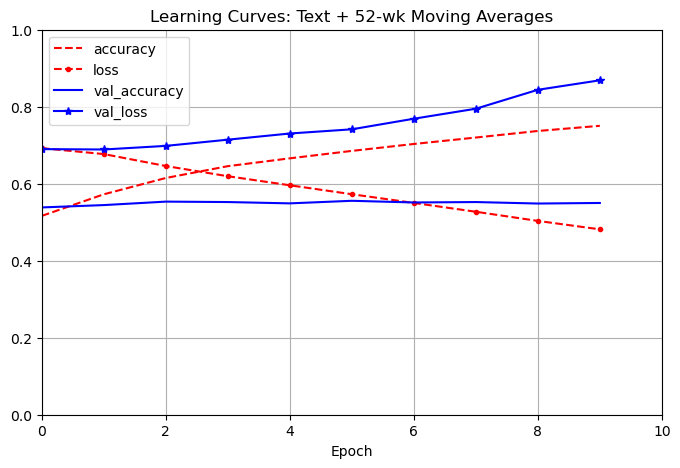

In [261]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0, 10], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--.', 'b-', 'b-*'])
plt.title('Learning Curves: Text + 52-wk Moving Averages')
plt.show()

In [263]:
# Select a specific week from the test set (e.g., October 2016)
target_week = '2016-09-19'  # Specify your target week here

# Filter the test data for the selected week
test_week_data = X_test[X_test['open_date_used'].dt.isocalendar().week == pd.to_datetime(target_week).isocalendar().week]

IndexError: Index dimension must be 1 or 2

In [347]:
#!pip install yfinance
import yfinance as yf

spy_df = yf.download('SPY', start=prices_df['date'].min(), end=prices_df['date'].max())
spy_df.reset_index(inplace=True)
spy_df['ticker'] = 'SPY'

[*********************100%***********************]  1 of 1 completed


In [348]:
# flatten the MultiIndex DataFrame spy_df
spy_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in spy_df.columns]

# Compute 52-week MA and percent diff for SPY
spy_df['52wk_ma'] = spy_df['Close_SPY'].rolling(window=252, min_periods=252).mean()
spy_df['spy_valuation_feature'] = (spy_df['Close_SPY'] - spy_df['52wk_ma']) / spy_df['52wk_ma']

# We only need the date and spy_valuation_feature
spy_df = spy_df[['Date_', 'spy_valuation_feature']].rename(columns={'Date_': 'date'})

In [349]:
# Drop any existing 'spy_valuation_feature' column from merged
if 'spy_valuation_feature' in merged.columns:
    merged = merged.drop(columns=['spy_valuation_feature'])

# merge SPY's valuation for that Friday
merged = merged.merge(
    spy_df,
    left_on='prev_friday',
    right_on='date',
    how='left'
)

# clean up
merged.drop(columns=['date'], inplace=True)

In [350]:
merged.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day,open_date_used,weekly_headlines,weekly_headlines_clean,prev_friday,valuation_feature,spy_valuation_feature
0,AAP,2010-01-08,40.639999,2010-01-11,2010-01-12,40.720001,39.430000,40.720001,UP,Monday,2010-01-11,Advance Auto Parts – A Turnaround Candidate (AAP),advance auto part – turnaround candidate aap,2010-01-08,NaN,NaN
1,ABC,2010-01-08,26.049999,2010-01-11,2010-01-12,26.240000,26.320000,26.240000,UP,Monday,2010-01-11,"Benzinga’s Top Downgrades (WEN, CMP, ACL, PPDI...",benzinga’s top downgrade wen cmp acl ppdi abc,2010-01-08,NaN,NaN
2,ACN,2010-01-08,42.570000,2010-01-11,2010-01-12,42.439999,42.209999,42.439999,DOWN,Monday,2010-01-11,Economic Effects Of Tiger’s Misses! Is There A...,economic effect tiger’s miss sex tape tiger wo...,2010-01-08,NaN,NaN
3,ADBE,2010-01-08,36.689999,2010-01-11,2010-01-12,36.680000,36.139999,36.680000,DOWN,Monday,2010-01-11,Silicon Valley Reeling Under High Vacancy Rate...,silicon valley reeling high vacancy rate cbg a...,2010-01-08,NaN,NaN
4,AET,2010-01-08,32.700001,2010-01-11,2010-01-12,32.770000,32.630001,32.770000,UP,Monday,2010-01-11,Positive Outlook And Better Guidance Results I...,positive outlook better guidance result upgrad...,2010-01-08,NaN,NaN


In [353]:
# Drop rows without necessary columns and create a copy of the DataFrame
rf_data = merged.dropna(subset=['weekly_headlines_clean', 'spy_valuation_feature', 'target']).copy()

# Normalize each stock’s valuation by subtracting the SPY valuation
rf_data['relative_valuation'] = rf_data['valuation_feature'] - rf_data['spy_valuation_feature']

In [354]:
rf_data.head()

,ticker,friday_date,friday_close,monday,tuesday,monday_open,tuesday_open,next_open,target,open_day,open_date_used,weekly_headlines,weekly_headlines_clean,prev_friday,valuation_feature,spy_valuation_feature,relative_valuation
8324,A,2010-12-31,29.635193,2011-01-03,2011-01-04,29.728184,30.035765,29.728184,UP,Monday,2011-01-03,Zacks #1 Rank Additions for Tuesday - Tale of...,zacks 1 rank addition tuesday tale tape zacks ...,2010-12-31,0.273816,0.114023,0.159793
8325,ABC,2010-12-31,34.119999,2011-01-03,2011-01-04,34.259998,34.430000,34.259998,UP,Monday,2011-01-03,Calls Purchased on AmerisourceBergen (ABC),call purchased amerisourcebergen abc,2010-12-31,0.129798,0.114023,0.015776
8326,ACN,2010-12-31,48.490002,2011-01-03,2011-01-04,48.660000,48.750000,48.660000,UP,Monday,2011-01-03,Top 4 Stocks In The Management Services Indust...,top 4 stock management service industry highes...,2010-12-31,0.161636,0.114023,0.047613
8327,ADBE,2010-12-31,30.780001,2011-01-03,2011-01-04,30.830000,31.280001,30.830000,UP,Monday,2011-01-03,"Market Roundup (BJ, M, JWN, LTD, HPQ, ADBE, AM...",market roundup bj m jwn ltd hpq adbe amzn mark...,2010-12-31,-0.013838,0.114023,-0.127860
8328,ADP,2010-12-31,40.632135,2011-01-03,2011-01-04,41.044779,41.229151,41.044779,UP,Monday,2011-01-03,Important Washington Events Next Week,important washington event next week,2010-12-31,0.085152,0.114023,-0.028871


In [355]:
# Encode labels
rf_data['target'] = rf_data['target'].map({'DOWN': 0, 'UP': 1})

# Features and labels
X = rf_data[['relative_valuation']]
y = rf_data['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.48982718992083085

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      6027
           1       0.48      0.48      0.48      5720

    accuracy                           0.49     11747
   macro avg       0.49      0.49      0.49     11747
weighted avg       0.49      0.49      0.49     11747



In [356]:
prices_df.head()

,date,ticker,open,close,low,high,volume,52wk_ma,percent_from_52wk_avg
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,NaN,NaN
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,NaN,NaN
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,NaN,NaN
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,NaN,NaN
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,NaN,NaN


## Day-by-day Comparison and Modeling

In [7]:
# normalize dates to remove time & timezone info
news_1day = news_df.copy()
news_1day['date'] = pd.to_datetime(news_1day['date'], utc=True)
news_1day['date'] = news_1day['date'].dt.tz_localize(None).dt.normalize()

# ensure price dates are also normalized
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df['date'] = prices_df['date'].dt.normalize()

# limit news to same range as prices
min_price_date = prices_df['date'].min()
max_price_date = prices_df['date'].max()

news_1day = news_1day[
    (news_1day['date'] >= min_price_date) &
    (news_1day['date'] <= max_price_date)
]

# get previous trading day per ticker
# sort and shift to get the previous trading day for each ticker
prices_1day = prices_df[['ticker', 'date', 'close']].copy()
prices_1day = prices_1day.sort_values(['ticker', 'date'])
prices_1day['prev_trading_date'] = prices_1day.groupby('ticker')['date'].shift(1)

# merge with news from the previous trading day
merged_with_news = pd.merge(
    prices_1day,
    news_1day[['ticker', 'date', 'headline']],
    left_on=['ticker', 'prev_trading_date'],
    right_on=['ticker', 'date'],
    how='left'
)

# rename to avoid confusion
news_with_price = merged_with_news.rename(columns={
    'date_x': 'date',            # trading date
    'date_y': 'headline_date'    # date of the news
})

In [8]:
# aggregate headlines per (ticker, trading day)
headline_agg = news_with_price.groupby(['ticker', 'date'])['headline'] \
    .apply(lambda x: " ".join(x.dropna())).reset_index()

# merge aggregated headlines back with prices_1day
merged_1day = pd.merge(
    prices_1day,
    headline_agg,
    on=['ticker', 'date'],
    how='left'
).rename(columns={'headline': 'headlines_prev_day'})

# add target column: UP or DOWN
# get previous day close for each ticker
merged_1day = merged_1day.sort_values(['ticker', 'date'])
merged_1day['prev_close'] = merged_1day.groupby('ticker')['close'].shift(1)

# create target column
merged_1day['target'] = np.where(
    merged_1day['close'] > merged_1day['prev_close'],
    'UP', 'DOWN'
)

# reorder columns for clarity
merged_1day = merged_1day[['ticker', 'date', 'prev_trading_date', 'prev_close', 'headlines_prev_day', 'close', 'target']]

# drop rows without headlines
merged_1day = merged_1day[
    merged_1day['headlines_prev_day'].fillna('').str.strip() != ''
]

# reset index
merged_1day.reset_index(drop=True, inplace=True)

In [9]:
# clean and lemmatize headlines
merged_1day['headlines_prev_day_clean'] = merged_1day['headlines_prev_day'].apply(clean)

In [10]:
merged_1day.head()

,ticker,date,prev_trading_date,prev_close,headlines_prev_day,close,target,headlines_prev_day_clean
0,A,2010-02-16,2010-02-12,21.444921,Agilent Technologies (A) Reports 23% Profit Ri...,21.638054,UP,agilent technology a report 23 profit rise ben...
1,A,2010-02-18,2010-02-17,21.909872,The Google Buzz Guide for the Enterprise (with...,22.160229,UP,google buzz guide enterprise with buzz matrix
2,A,2010-03-11,2010-03-10,24.077253,BRKR Buys VARI’s Assets; Deal To Be Accretive ...,24.020029,DOWN,brkr buy vari’s asset deal accretive 201011
3,A,2010-03-12,2010-03-11,24.020029,The Health Care Reform Bill: Welcome To The Bi...,23.905579,DOWN,health care reform bill welcome biggest tax in...
4,A,2010-03-25,2010-03-24,24.248926,IBD Takedown of the Health Insurance Law,24.713877,UP,ibd takedown health insurance law


In [419]:
# vectorize cleaned 1 day headlines
print("Vectorizing text...")
tfidf = TfidfVectorizer(max_features=5000) 
X_text_1d = tfidf.fit_transform(merged_1day['headlines_prev_day_clean'])

Vectorizing text...


In [421]:
# train randomforest classifier and measure train time
start = time.time()

X_1d = X_text_1d
y_1d = merged_1day['target']

# Save original indices
original_indices_1d = merged_1day.index

X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_1d, y_1d, original_indices_1d, test_size=0.2, random_state=42)

print("Training model...")
clf_1d = RandomForestClassifier(n_estimators=500, random_state=42)
clf_1d.fit(X_train, y_train)

train_time = time.time() - start
print('Time required to train model (sec): {:.1f}'.format(train_time))

Training model...
Time required to train model (sec): 888.2


In [422]:
y_pred = clf_1d.predict(X_test)

# confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
      DOWN    UP
DOWN  5716  5799
UP    4822  7265

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.54      0.50      0.52     11515
          UP       0.56      0.60      0.58     12087

    accuracy                           0.55     23602
   macro avg       0.55      0.55      0.55     23602
weighted avg       0.55      0.55      0.55     23602



In [425]:
# get predicted probabilities of going 'UP'
y_proba = clf_1d.predict_proba(X_test)
proba_up = y_proba[:, 1]

# create dataframe to assess top predictions
results = pd.DataFrame({
    'ticker': merged_1day.loc[test_idx, 'ticker'].values,
    'prob_up': proba_up,
    'true_label': y_test,
    'headline': merged_1day.loc[test_idx, 'headlines_prev_day_clean'].values
})

# find top 20 most confident predictions for 'UP'
top_20_up = results.sort_values('prob_up', ascending=False).head(20)
print(top_20_up[['ticker', 'true_label', 'prob_up', 'headline']])

       ticker true_label  prob_up  \
38511     EOG         UP      1.0   
7178      AMP       DOWN      1.0   
35806      EA         UP      1.0   
90345      PH         UP      1.0   
88569     PEG         UP      1.0   
7365      AMT         UP      1.0   
43243      FE         UP      1.0   
28411       D         UP      1.0   
116113    XEL         UP      1.0   
28447       D         UP      1.0   
44842     FLS         UP      1.0   
25817     CPB         UP      1.0   
90169     PGR         UP      1.0   
35054     DUK         UP      1.0   
37163      ED         UP      1.0   
94347       R         UP      1.0   
56990     IPG         UP      1.0   
27110    CTSH         UP      1.0   
53722    HOLX         UP      1.0   
109007   URBN       DOWN      1.0   

                                                 headline  
38511               stock sector watch sp 500 recap 62011  
7178              zacks 1 rank addition tuesday tale tape  
35806                                     

In [439]:
# Find top 10 likeliest stocks to go up on a given day

# Step 1: set target day
target_day = pd.to_datetime("2016-09-06")
target_day_data = merged_1day[merged_1day['date'] == target_day]

# Step 2: Get the subset of test data from merged that matches this latest date
# Filter merged rows that are both in the test set and match the latest date
target_day_test_mask = target_day_data.index.isin(test_idx)
target_day_test = target_day_data[target_day_test_mask]

# Step 4: Get predictions for those test rows
X_target = tfidf.transform(target_day_test['headlines_prev_day'])
pred_probs = clf_1d.predict_proba(X_target)  # Assuming binary classification with 'DOWN' and 'UP'
up_probs = pred_probs[:, list(clf_1d.classes_).index('UP')]  # Probabilities of going UP

# Step 5: Add predictions back to the test DataFrame
target_day_test = target_day_test.copy()
target_day_test['prob_up'] = up_probs

# Step 6: Sort by probability of going up and select top 10
top_10 = target_day_test.sort_values('prob_up', ascending=False).head(10)

# Display the top 10 likeliest stocks to go up on that trading day
print(top_10[['ticker', 'date', 'prob_up']])

       ticker       date   prob_up
86884     OXY 2016-09-06  0.771259
9914     AVGO 2016-09-06  0.587933
79442      MU 2016-09-06  0.493168
29463     DAL 2016-09-06  0.492667
9423     ATVI 2016-09-06  0.492033
49686     GPS 2016-09-06  0.427456
13814     BHI 2016-09-06  0.343917
22017   CMCSA 2016-09-06  0.336333
6804      ALL 2016-09-06  0.334218
110982   VRSN 2016-09-06  0.143495


In [440]:
# assess predictive performance

# Make a copy of the top_10 predictions
top_10_eval = top_10.copy()

# Calculate absolute price change
top_10_eval['abs_price_change'] = (top_10_eval['close'] - top_10_eval['prev_close'])

# Calculate percentage change
top_10_eval['pct_price_change'] = ((top_10_eval['close'] - top_10_eval['prev_close']) / top_10_eval['prev_close']) * 100

# Display relevant columns
print(top_10_eval[['ticker', 'date', 'prev_close', 'close', 'abs_price_change', 'pct_price_change', 'prob_up']])

       ticker       date  prev_close       close  abs_price_change  \
86884     OXY 2016-09-06   77.510002   78.000000          0.489998   
9914     AVGO 2016-09-06  173.110001  171.100006         -2.009995   
79442      MU 2016-09-06   16.700001   17.010000          0.309999   
29463     DAL 2016-09-06   37.169998   36.820000         -0.349998   
9423     ATVI 2016-09-06   42.799999   43.509998          0.709999   
49686     GPS 2016-09-06   23.920000   23.430000         -0.490000   
13814     BHI 2016-09-06   49.779999   49.959999          0.180000   
22017   CMCSA 2016-09-06   66.160004   66.339996          0.179992   
6804      ALL 2016-09-06   68.949997   69.309998          0.360001   
110982   VRSN 2016-09-06   79.019997   76.199997         -2.820000   

        pct_price_change   prob_up  
86884           0.632174  0.771259  
9914           -1.161109  0.587933  
79442           1.856281  0.493168  
29463          -0.941614  0.492667  
9423            1.658876  0.492033  
49686  

## Back testing: assess model performance over time

For each day, select the top 5 model-predicted stocks, calculate the average return across the 5 picks for that day, and cumulatively sum the daily average returns. Finally compare the cumulative returns to the S&P 500.

In [443]:
# create a DataFrame of test predictions
test_preds_df = pd.DataFrame({
    'index': test_idx,
    'prob_up': proba_up
})

# merge predictions with test subset of merged_1day
# Reset index to allow merge on 'index'
merged_test = merged_1day.reset_index().merge(test_preds_df, on='index')

In [465]:
# add % return column
merged_test['daily_return_pct'] = ((merged_test['close'] - merged_test['prev_close']) / merged_test['prev_close']) * 100

# sort by date and prob_up
sorted_preds = merged_test.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# get top 5 picks per day
top5_daily = sorted_preds.groupby('date').head(5)

# calculate average return for top 5 picks per day
daily_avg_return = top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return over time (compounded)
daily_avg_return['cumulative_return_pct'] = (1 + daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [466]:
 # compare to S&P 500
import yfinance as yf

# get S&P 500 data for the same date range
start_date = daily_avg_return['date'].min()
end_date = daily_avg_return['date'].max()
sp500 = yf.download("^GSPC", start=start_date, end=end_date)

# ensure index is datetime and trimmed to match your data
sp500 = sp500[['Open', 'Close']]
sp500 = sp500.reset_index()  # brings 'Date' into a column
sp500.rename(columns={'Date': 'date'}, inplace=True)  # match column name with daily_avg_return

# prepare the S&P 500 daily % returns and cumulative return
sp500['daily_return_pct'] = ((sp500['Close'] - sp500['Open']) / sp500['Open']) * 100
sp500['sp500_cum_return_pct'] = (1 + sp500['daily_return_pct'] / 100).cumprod() - 1
sp500['sp500_cum_return_pct'] *= 100

# ensure both DataFrames have 'date' as a column and flat index
daily_avg_return = daily_avg_return.reset_index(drop=True)
sp500 = sp500.reset_index(drop=True)

# double-check 'date' is datetime type
daily_avg_return['date'] = pd.to_datetime(daily_avg_return['date'])
sp500['date'] = pd.to_datetime(sp500['date'])

# flatten all multi-level columns (if any)
daily_avg_return.columns = [col if isinstance(col, str) else col[0] for col in daily_avg_return.columns]
sp500.columns = [col if isinstance(col, str) else col[0] for col in sp500.columns]

# merge with model returns
comparison_df = daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

[*********************100%***********************]  1 of 1 completed


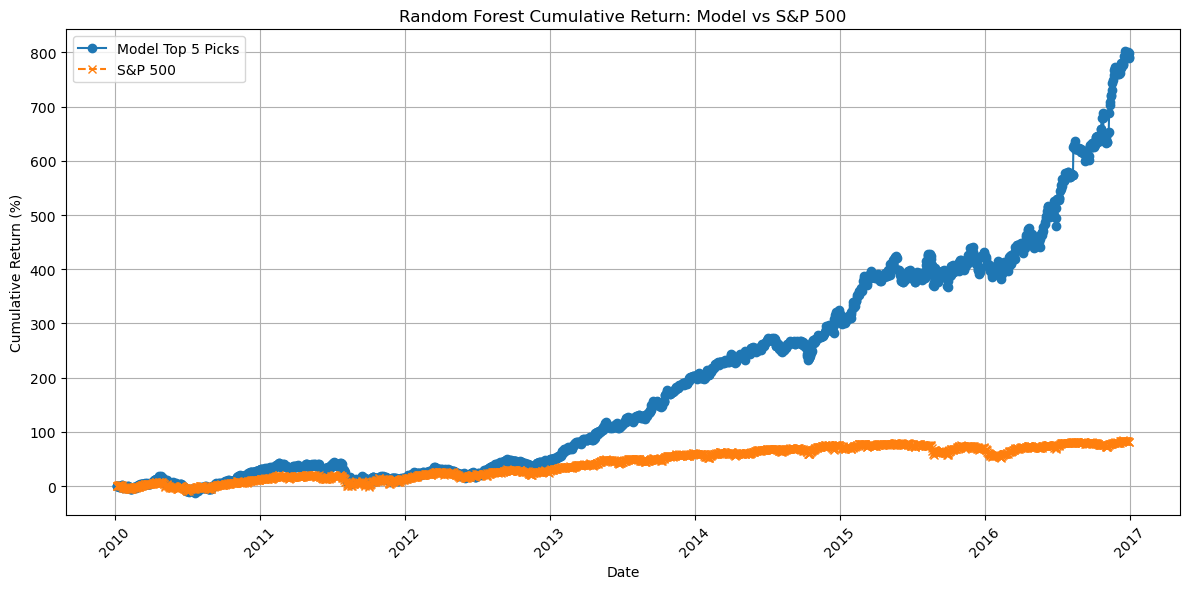

In [528]:
# plot model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['date'], comparison_df['cumulative_return_pct'], label='Model Top 5 Picks', marker='o')
plt.plot(comparison_df['date'], comparison_df['sp500_cum_return_pct'], label='S&P 500', linestyle='--', marker='x')

plt.title("Random Forest Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rf_cumulative_return_comparison.png', format='png') 
plt.show()

In [474]:

# find date of max avg return
idx_of_max = daily_avg_return['avg_top5_return_pct'].idxmax()
row_with_max = daily_avg_return.loc[idx_of_max]
max_avg_return_date = row_with_max['date']  # This must be a datetime, not a float

# Create a range of dates
start_date = max_avg_return_date - pd.Timedelta(days=5)
end_date = max_avg_return_date + pd.Timedelta(days=5)

# Filter for 5 days before and after max date
top_picks_around_max = top5_daily[top5_daily['date'].between(start_date, end_date)]

top_picks_around_max.head(20)

,index,ticker,date,prev_trading_date,prev_close,headlines_prev_day,close,target,headlines_prev_day_clean,prob_up,daily_return_pct
12892,63792,KR,2016-08-08,2016-08-05,32.619999,Argus Would Like To Add Whole Foods To The Buy...,32.310001,DOWN,argus would like add whole food buy list cant ...,0.851767,-0.950331
22439,112293,VZ,2016-08-08,2016-08-05,53.639999,Yahoo Messenger to Shut Down Operation on Friday,53.590000,DOWN,yahoo messenger shut operation friday,0.789691,-0.093212
10019,49673,GPS,2016-08-08,2016-08-05,25.639999,Option Alert: GPS Dec16 23.0 Puts Sweep: 1400 ...,25.620001,DOWN,option alert gps dec16 230 put sweep 1400 ask ...,0.644000,-0.077995
3146,15399,BLL,2016-08-08,2016-08-05,79.150002,Jefferies Drafts Ball Corporation As Its Franc...,80.199997,UP,jefferies draft ball corporation franchise pic...,0.572344,1.326589
18908,94183,QCOM,2016-08-08,2016-08-05,62.000000,"Qualcomm, Baidu Announce Commercialization of ...",61.580002,DOWN,qualcomm baidu announce commercialization izat...,0.556321,-0.677416
8804,43467,FIS,2016-08-09,2016-08-08,79.410004,Barron's: How To Find Safe 5% Yields,79.730003,UP,barrons find safe 5 yield,0.940947,0.402971
3100,15194,BLK,2016-08-09,2016-08-08,371.690002,Goldman Sachs Removes BlackRock From Convictio...,368.649994,DOWN,goldman sachs remove blackrock conviction buy ...,0.684500,-0.817888
10235,50826,HAL,2016-08-09,2016-08-08,44.259998,National-Oilwell Varco's 50-Day Moving Average...,44.049999,DOWN,nationaloilwell varcos 50day moving average so...,0.629561,-0.474467
19889,99209,SLB,2016-08-09,2016-08-08,82.500000,National-Oilwell Varco's 50-Day Moving Average...,81.830002,DOWN,nationaloilwell varcos 50day moving average so...,0.620001,-0.812119
2814,13810,BHI,2016-08-09,2016-08-08,47.990002,National-Oilwell Varco's 50-Day Moving Average...,47.849998,DOWN,nationaloilwell varcos 50day moving average so...,0.612561,-0.291736


In [479]:
print(max_avg_return_date)

2016-08-11 00:00:00


In [478]:
# Filter for M or KSS on 2016-08-11
headline_row = top_picks_around_max[
    (top_picks_around_max['ticker'] == 'KSS') & 
    (top_picks_around_max['date'] == pd.Timestamp('2016-08-11'))
]

# Display full headline text(s)
print(headline_row['headlines_prev_day'].values)

["Kohl's Announces Adrianne Shapira As New Board Member Effective Immediately Better Weather May Have Helped Kohl's In Q2 Lazy Days of Summer Continue, But Market Keeps Posting All-Time Highs Option Alert: KSS Aug16 37.5 Calls: 6000 @  Above Ask!  $2.20: 6020 traded vs 2917 OI:  Earnings tmrrw Before Open  $38.52 Ref"]


In [480]:
daily_avg_return.head()

,date,avg_top5_return_pct,cumulative_return_pct
0,2010-01-05,0.337098,0.337098
1,2010-01-06,-0.178632,0.157864
2,2010-01-07,0.504875,0.663536
3,2010-01-08,-0.527060,0.132979
4,2010-01-11,-0.266825,-0.134201


In [501]:
top5_daily.head()

,index,ticker,date,prev_trading_date,prev_close,headlines_prev_day,close,target,headlines_prev_day_clean,prob_up,daily_return_pct
21648,108288,UDR,2010-01-05,2010-01-04,16.209999,S&P Energy and Financial Picks – Unloved by St...,16.190001,DOWN,sp energy financial pick – unloved street,0.917076,-0.123368
16289,81084,NEM,2010-01-05,2010-01-04,48.450001,"Gold Gains Traction (GLD, GDX, IAG, NEM, ABX)",48.580002,UP,gold gain traction gld gdx iag nem abx,0.624063,0.268320
21952,109799,VLO,2010-01-05,2010-01-04,16.352831,Refiners Are Lifted By A Rise In Refined Products,16.773310,UP,refiner lifted rise refined product,0.468840,2.571292
5941,29505,DD,2010-01-05,2010-01-04,32.535613,"Commodity And Oil Prices Higher In 2010, Share...",32.222220,DOWN,commodity oil price higher 2010 share move fcx...,0.452129,-0.963231
21261,106355,TSO,2010-01-05,2010-01-04,14.810000,Refiners Are Lifted By A Rise In Refined Produ...,14.800000,DOWN,refiner lifted rise refined product today upgr...,0.365699,-0.067522


In [481]:

mean_daily_avg_return = daily_avg_return['avg_top5_return_pct'].mean()
print(mean_daily_avg_return)

0.13396214838287146


In [482]:
annualized_return = mean_daily_avg_return * 252
print(annualized_return)

33.75846139248361


In [490]:

value = daily_avg_return.loc[daily_avg_return['date'] == '2014-12-31', 'cumulative_return_pct'].values[0]
print(value)

316.61062587654845


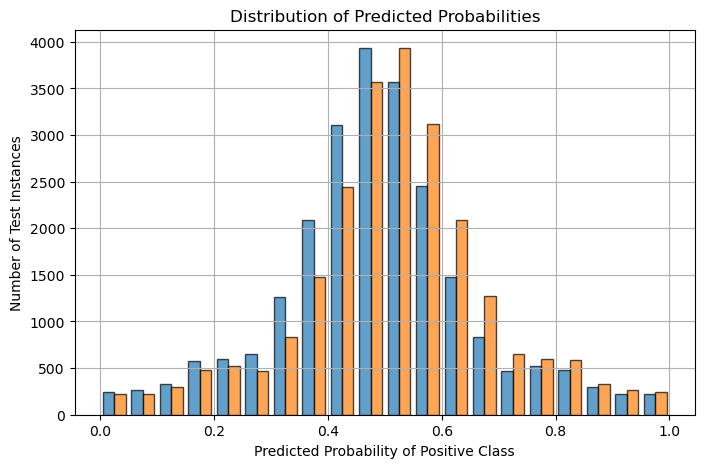

In [500]:
# distribution of predicted probabilities
plt.figure(figsize=(8, 5))
plt.hist(y_proba, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.grid(True)
plt.show()

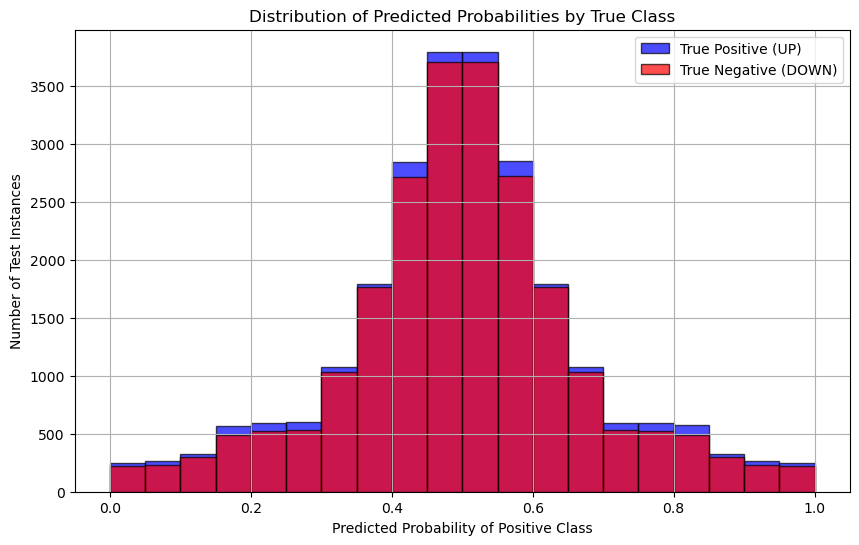

In [499]:
y_test_array = np.array(y_test)

# Then split the predicted probabilities based on true labels
probs_positive = y_proba[y_test_array == 'UP']
probs_negative = y_proba[y_test_array == 'DOWN']

probs_positive = probs_positive.flatten()
probs_negative = probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(probs_positive, bins=20, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(probs_negative, bins=20, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
plt.show()

## Neural Network w/ daily data

In [511]:
# Build model
daily_nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(128,activation='relu'),
    Dropout(0.6),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

daily_nn_model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [512]:
# Compile model
daily_nn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [513]:
y_train_nn = y_train.map({'DOWN': 0, 'UP': 1}).astype(int)
y_test_nn = y_test.map({'DOWN': 0, 'UP': 1}).astype(int)

X_train_dense = X_train.toarray().astype('float32')
X_test_dense = X_test.toarray().astype('float32')

start = time.time()

# Train model
history = daily_nn_model.fit(
    X_train_dense, y_train_nn,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Predict and evaluate
y_pred_probs_daily_nn = daily_nn_model.predict(X_test_dense)
y_pred_daily_nn = (y_pred_probs_daily_nn > 0.5).astype("int32")
acc = accuracy_score(y_test_nn, y_pred_daily_nn)

train_time = time.time() - start

print(f"Accuracy: {acc:.4f} |Train time: {train_time:.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_nn, y_pred_daily_nn))
print("Classification Report:\n", classification_report(y_test_nn, y_pred_daily_nn))

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5036 - loss: 0.6931 - val_accuracy: 0.5189 - val_loss: 0.6920
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5489 - loss: 0.6873 - val_accuracy: 0.5269 - val_loss: 0.6913
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6003 - loss: 0.6653 - val_accuracy: 0.5288 - val_loss: 0.6964
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6371 - loss: 0.6354 - val_accuracy: 0.5325 - val_loss: 0.7123
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6804 - loss: 0.5952 - val_accuracy: 0.5381 - val_loss: 0.7270
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7211 - loss: 0.5505 - val_accuracy: 0.5388 - val_loss: 0.7518
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7501 - loss: 0.5095 - val_accuracy: 0.5430 - val_loss: 0.7753
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7731 - loss: 0.4717 - val_accuracy: 0.

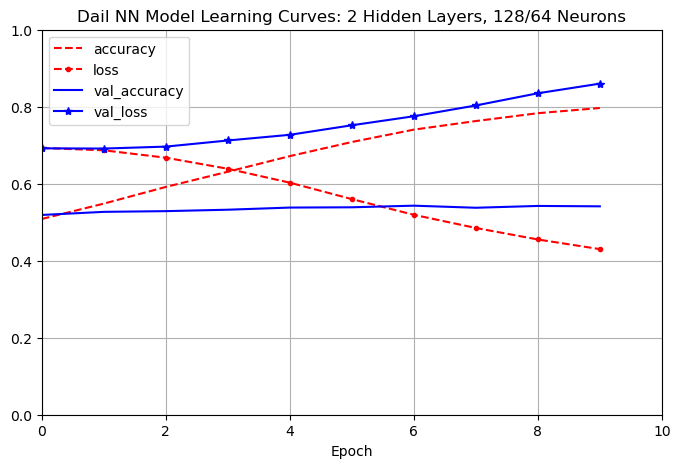

In [514]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0, 10], ylim=[0, 1], grid=True, xlabel='Epoch',
    style=['r--', 'r--.', 'b-', 'b-*'])
plt.title('Dail NN Model Learning Curves: 2 Hidden Layers, 128/64 Neurons')
plt.show()

In [520]:
# evaluate performance as cumulative returns for top 5 daily picks

# calculated probabilities of UP
nn_proba_up = y_pred_probs_daily_nn.flatten()

# create a DataFrame of test predictions
nn_test_preds_df = pd.DataFrame({
    'index': test_idx,
    'prob_up': nn_proba_up
})

# merge predictions with test subset of merged_1day
# Reset index to allow merge on 'index'
nn_merged_test = merged_1day.reset_index().merge(nn_test_preds_df, on='index')

In [521]:
# add % return column
nn_merged_test['daily_return_pct'] = ((nn_merged_test['close'] - nn_merged_test['prev_close']) / nn_merged_test['prev_close']) * 100

# sort by date and prob_up
nn_sorted_preds = nn_merged_test.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# get top 5 picks per day
nn_top5_daily = nn_sorted_preds.groupby('date').head(5)

# calculate average return for top 5 picks per day
nn_daily_avg_return = nn_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
nn_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return over time (compounded)
nn_daily_avg_return['cumulative_return_pct'] = (1 + nn_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
nn_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

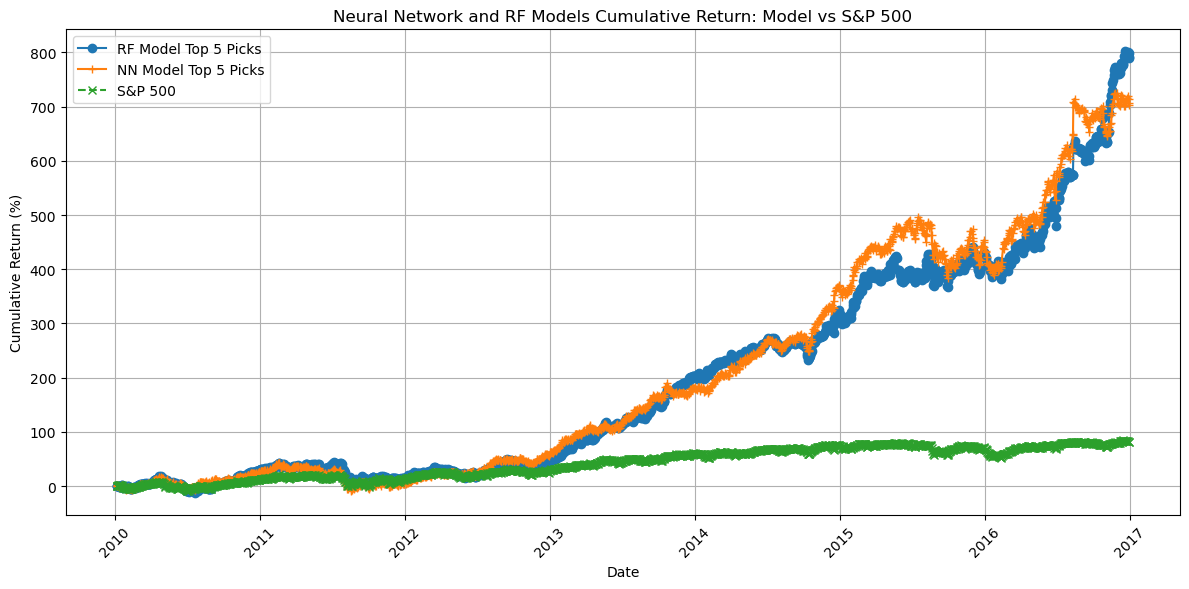

In [527]:
# ensure both DataFrames have 'date' as a column and flat index
nn_daily_avg_return = nn_daily_avg_return.reset_index(drop=True)
sp500 = sp500.reset_index(drop=True)

# double-check 'date' is datetime type
nn_daily_avg_return['date'] = pd.to_datetime(nn_daily_avg_return['date'])

# merge with model returns
nn_comparison_df = nn_daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

# plot model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['date'], comparison_df['cumulative_return_pct'], label='RF Model Top 5 Picks', marker='o')
plt.plot(nn_comparison_df['date'], nn_comparison_df['cumulative_return_pct'], label='NN Model Top 5 Picks', marker='+')
plt.plot(nn_comparison_df['date'], nn_comparison_df['sp500_cum_return_pct'], label='S&P 500', linestyle='--', marker='x')

plt.title("Neural Network and RF Models Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('nn_rf_cumulative_return_comparison.png', format='png') 
plt.show()

## Stacked Model: Neural Network + Random Forest => Logistic Regression

In [537]:
# split the test data 80/20 to train the meta model and validate
# with held out data
X_test_dense_train, X_test_dense_holdout, X_test_train, X_test_holdout, y_test_nn_train, y_test_nn_holdout, test_train_idx, test_holdout_idx = train_test_split(
    X_test_dense, X_test, y_test_nn, test_idx, test_size=0.2, random_state=42, stratify=y_test_nn
)

# get stacking features (predicted probs) for meta-model training (on 80% test data)
p_nn_test_train = daily_nn_model.predict(X_test_dense_train).flatten()
p_rf_test_train = clf_1d.predict_proba(X_test_train)[:, 1]

# combine stacking features
X_meta_test_train = np.vstack((p_nn_test_train, p_rf_test_train)).T

591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step


In [538]:
# train meta-model on stacking features
meta_model_final = LogisticRegression()
meta_model_final.fit(X_meta_test_train, y_test_nn_train)

LogisticRegression()

In [539]:
# evaluate using held out data
# Get stacking features for final holdout
p_nn_holdout = daily_nn_model.predict(X_test_dense_holdout).flatten()
p_rf_holdout = clf_1d.predict_proba(X_test_holdout)[:, 1]

# combine stacking features
X_meta_holdout = np.vstack((p_nn_holdout, p_rf_holdout)).T

# final evaluation
y_probs_holdout = meta_model_final.predict_proba(X_meta_holdout)[:, 1]
y_pred_holdout = (y_probs_holdout > 0.5).astype("int32")

print("Final stacked model accuracy on unseen holdout test set:", accuracy_score(y_test_nn_holdout, y_pred_holdout))
print(classification_report(y_test_nn_holdout, y_pred_holdout))

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
Final stacked model accuracy on unseen holdout test set: 0.5420461766574878
              precision    recall  f1-score   support

           0       0.54      0.46      0.49      2303
           1       0.55      0.62      0.58      2418

    accuracy                           0.54      4721
   macro avg       0.54      0.54      0.54      4721
weighted avg       0.54      0.54      0.54      4721



In [540]:
# evaluate performance as cumulative returns for top 5 daily picks

# calculated probabilities of UP
meta_proba_up = y_pred_holdout.flatten()

# create a DataFrame of hold out predictions
meta_holdout_preds_df = pd.DataFrame({
    'index': test_holdout_idx,
    'prob_up': meta_proba_up
})

# merge predictions with test subset of merged_1day
# Reset index to allow merge on 'index'
meta_merged_holdout = merged_1day.reset_index().merge(meta_holdout_preds_df, on='index')

In [543]:
# add % return column
meta_merged_holdout['daily_return_pct'] = ((meta_merged_holdout['close'] - meta_merged_holdout['prev_close']) / meta_merged_holdout['prev_close']) * 100

# FILTER: Only keep rows where predicted probability > 0.65
meta_confident_preds = meta_merged_holdout[meta_merged_holdout['prob_up'] > 0.65]

# sort by date and prob_up
meta_sorted_preds = meta_confident_preds.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# get top 5 picks per day
meta_top5_daily = meta_sorted_preds.groupby('date').head(5)

# calculate average return for top 5 picks per day
meta_daily_avg_return = meta_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
meta_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return over time (compounded)
meta_daily_avg_return['cumulative_return_pct'] = (1 + meta_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
meta_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

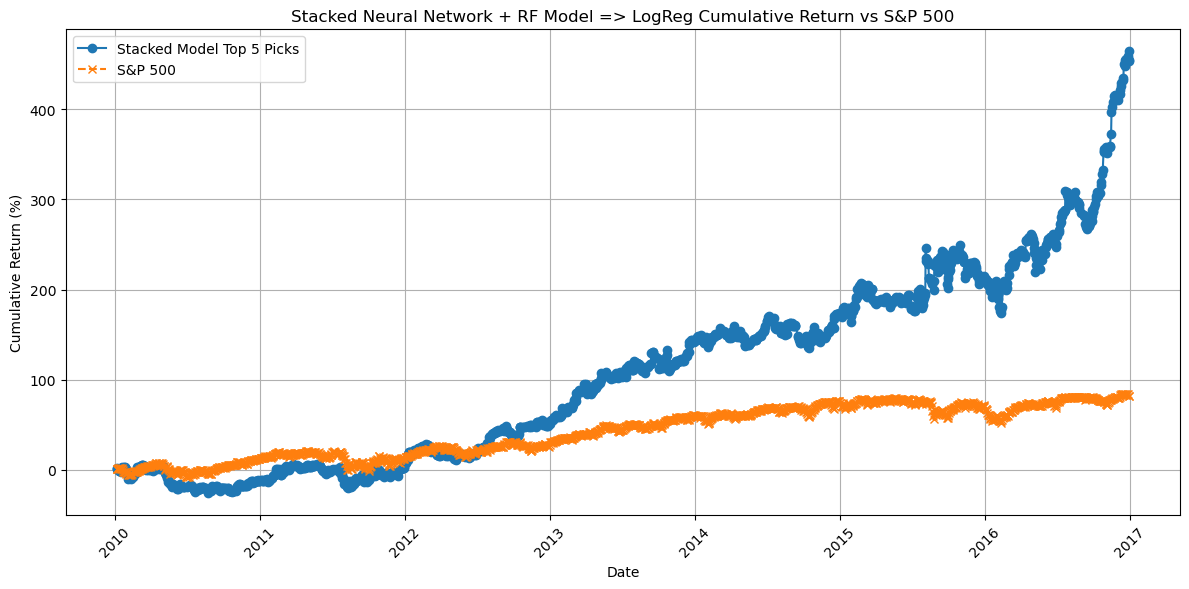

In [546]:
# ensure both DataFrames have 'date' as a column and flat index
meta_daily_avg_return = meta_daily_avg_return.reset_index(drop=True)
sp500 = sp500.reset_index(drop=True)

# double-check 'date' is datetime type
meta_daily_avg_return['date'] = pd.to_datetime(meta_daily_avg_return['date'])

# merge with model returns
meta_comparison_df = meta_daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

# plot model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
# plt.plot(comparison_df['date'], comparison_df['cumulative_return_pct'], label='RF Model Top 5 Picks', marker='o')
plt.plot(meta_comparison_df['date'], meta_comparison_df['cumulative_return_pct'], label='Stacked Model Top 5 Picks', marker='o')
plt.plot(comparison_df['date'], comparison_df['sp500_cum_return_pct'], label='S&P 500', linestyle='--', marker='x')

plt.title("Stacked Neural Network + RF Model => LogReg Cumulative Return vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('meta_cumulative_return_comparison.png', format='png') 
plt.show()

<Axes: xlabel='date'>

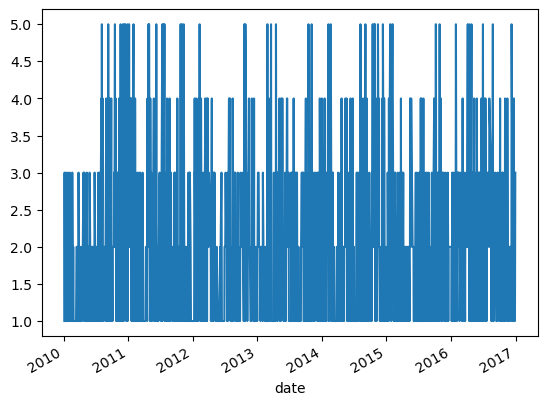

In [545]:
meta_top5_daily.groupby('date').size().plot()

In [552]:
# compare daily average returns
# random forest
mean_daily_avg_return = daily_avg_return['avg_top5_return_pct'].mean()
print(f"Random Forest Average Daily Return: {mean_daily_avg_return:.4f}%")

# neural network
nn_mean_daily_avg_return = nn_daily_avg_return['avg_top5_return_pct'].mean()
print(f"Neural Network Average Daily Return: {nn_mean_daily_avg_return:.4f}%")

# stacked model
meta_mean_daily_avg_return = meta_daily_avg_return['avg_top5_return_pct'].mean()
print(f"Stacked Model Average Daily Return: {meta_mean_daily_avg_return:.4f}%")

Random Forest Average Daily Return: 0.1340%
Neural Network Average Daily Return: 0.1282%
Stacked Model Average Daily Return: 0.1452%


# Update all models: Train-Test to Split on Dates Only

In [555]:
merged_1day.head()

,ticker,date,prev_trading_date,prev_close,headlines_prev_day,close,target,headlines_prev_day_clean
0,A,2010-02-16,2010-02-12,21.444921,Agilent Technologies (A) Reports 23% Profit Ri...,21.638054,UP,agilent technology a report 23 profit rise ben...
1,A,2010-02-18,2010-02-17,21.909872,The Google Buzz Guide for the Enterprise (with...,22.160229,UP,google buzz guide enterprise with buzz matrix
2,A,2010-03-11,2010-03-10,24.077253,BRKR Buys VARI’s Assets; Deal To Be Accretive ...,24.020029,DOWN,brkr buy vari’s asset deal accretive 201011
3,A,2010-03-12,2010-03-11,24.020029,The Health Care Reform Bill: Welcome To The Bi...,23.905579,DOWN,health care reform bill welcome biggest tax in...
4,A,2010-03-25,2010-03-24,24.248926,IBD Takedown of the Health Insurance Law,24.713877,UP,ibd takedown health insurance law


### Train-Val-Test Split

In [11]:
# Separate data into train (60%), val (20%), and test (20%) sets

# get unique dates
unique_dates = merged_1day['date'].unique()

# split the dates into (train+val) and test
trainval_dates, test_dates = train_test_split(
    unique_dates, test_size=0.2, random_state=42)

# split trainval_dates into train and validation sets:
train_dates, val_dates = train_test_split(
    trainval_dates, test_size=0.25, random_state=42)

merged_1day_train = merged_1day[merged_1day['date'].isin(train_dates)]
merged_1day_val = merged_1day[merged_1day['date'].isin(val_dates)]
merged_1day_test = merged_1day[merged_1day['date'].isin(test_dates)]

# preserve indices for retrieval of headline and price data after model evaluation
train_indices = merged_1day_train.index
val_indices = merged_1day_val.index
test_indices = merged_1day_test.index

# separate X and y
X_train = merged_1day_train['headlines_prev_day_clean']
X_val = merged_1day_val['headlines_prev_day_clean']
X_test = merged_1day_test['headlines_prev_day_clean']
y_train = merged_1day_train['target'].map({'DOWN': 0, 'UP': 1}).astype(int)
y_val = merged_1day_val['target'].map({'DOWN': 0, 'UP': 1}).astype(int)
y_test = merged_1day_test['target'].map({'DOWN': 0, 'UP': 1}).astype(int)

In [12]:
# verify the split sizes and confirm no overlapping dates

# size of original data
total_size = len(merged_1day)

# sizes of the splits
train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

# Fractions
print(f"Train fraction: {train_size / total_size:.3f}")
print(f"Validation fraction: {val_size / total_size:.3f}")
print(f"Test fraction: {test_size / total_size:.3f}")
print(f"Total fraction: {(train_size + val_size + test_size) / total_size:.3f}")
print()

# collect dates in each set
dates_train = merged_1day.loc[X_train.index, 'date']
dates_val = merged_1day.loc[X_val.index, 'date']
dates_test = merged_1day.loc[X_test.index, 'date']

# convert to sets
set_train_dates = set(dates_train)
set_val_dates = set(dates_val)
set_test_dates = set(dates_test)

# check overlaps
train_val_overlap = set_train_dates.intersection(set_val_dates)
train_test_overlap = set_train_dates.intersection(set_test_dates)
val_test_overlap = set_val_dates.intersection(set_test_dates)

# Print results
print(f"Overlap between train and val dates: {len(train_val_overlap)}")
print(f"Overlap between train and test dates: {len(train_test_overlap)}")
print(f"Overlap between val and test dates: {len(val_test_overlap)}")

Train fraction: 0.602
Validation fraction: 0.200
Test fraction: 0.198
Total fraction: 1.000

Overlap between train and val dates: 0
Overlap between train and test dates: 0
Overlap between val and test dates: 0


### Build and Tune Random Forest

In [18]:
# build pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# parameter grid to search
param_grid = {
    'tfidf__max_features': [5000, 10000],
    'rf__n_estimators': [200, 400],
    'rf__max_depth': [None]
}

# stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

In [19]:
# time estimates and progress bar for GridSearchCV

# progress bar does not work inside jupyter notebook
class GridSearchCVProgress(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        n_candidates = len(self.param_grid) if isinstance(self.param_grid, list) else np.prod([len(v) for v in self.param_grid.values()])
        n_splits = self.cv if isinstance(self.cv, int) else self.cv.get_n_splits()
        total = n_candidates * n_splits
        
        with tqdm(total=total, desc="GridSearchCV Progress", ncols=100) as pbar:
            old_score = self._score
        
            def _score_with_progress(*args, **kwargs):
                pbar.update(1)
                return old_score(*args, **kwargs)
            
            self._score = _score_with_progress
            return super().fit(X, y, **fit_params)

# estimate time to search
sample_frac = 0.05  # 5% sample
X_sample = X_train.sample(frac=sample_frac, random_state=42)
y_sample = y_train.loc[X_sample.index]

# create 1 fold manually
train_idx, val_idx = next(iter(skf.split(X_sample, y_sample)))
X_fold_train, y_fold_train = X_sample.iloc[train_idx], y_sample.iloc[train_idx]
X_fold_val, y_fold_val = X_sample.iloc[val_idx], y_sample.iloc[val_idx]

rf_pipeline_clone = clone(rf_pipeline)

start = time.time()
rf_pipeline_clone.fit(X_fold_train, y_fold_train)
_ = rf_pipeline_clone.predict(X_fold_val)
time_per_fold_sample = time.time() - start

correction_factor = 1 / sample_frac
time_per_fold_full = time_per_fold_sample * correction_factor

# estimate total time
n_candidates = len(param_grid) if isinstance(param_grid, list) else np.prod([len(v) for v in param_grid.values()])
n_folds = 5

estimated_total_time = time_per_fold_full * n_candidates * n_folds

print(f"Estimated total GridSearchCV time: {estimated_total_time/60:.2f} minutes (~{estimated_total_time/3600:.2f} hours)")

Estimated total GridSearchCV time: 8.27 minutes (~0.14 hours)


In [20]:
# fit on the training set
start = time.time()
rf_grid.fit(X_train, y_train)
train_time = time.time() - start
print('Time required to tune model (min): {:.1f}'.format(train_time/60))

# best model
print(f"Best RF Parameters: {rf_grid.best_params_}")
print(f"Best RF CV Accuracy: {rf_grid.best_score_:.4f}")

# get the best pipeline
best_rf_model = rf_grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END rf__max_depth=None, rf__n_estimators=200, tfidf__max_features=10000;, score=0.554 total time= 7.2min
[CV 1/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=10000;, score=0.554 total time=14.9min
[CV 5/5] END rf__max_depth=None, rf__n_estimators=200, tfidf__max_features=5000;, score=0.557 total time= 5.9min
[CV 3/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.555 total time=13.0min
[CV 3/5] END rf__max_depth=None, rf__n_estimators=200, tfidf__max_features=10000;, score=0.556 total time= 7.2min
[CV 4/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.551 total time=13.0min
[CV 2/5] END rf__max_depth=None, rf__n_estimators=200, tfidf__max_features=10000;, score=0.553 total time= 7.2min
[CV 5/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.558 total time=13.0min
[CV 2/5] END rf__max_depth=None,

In [ ]:
rf_probs = best_rf_model.predict_proba(X_val)
rf_y_proba = rf_probs[:, 1]
rf_y_pred = (rf_y_proba > 0.5).astype("int32")
rf_acc = accuracy_score(y_val, rf_y_pred)

Validation Accuracy: 0.5034


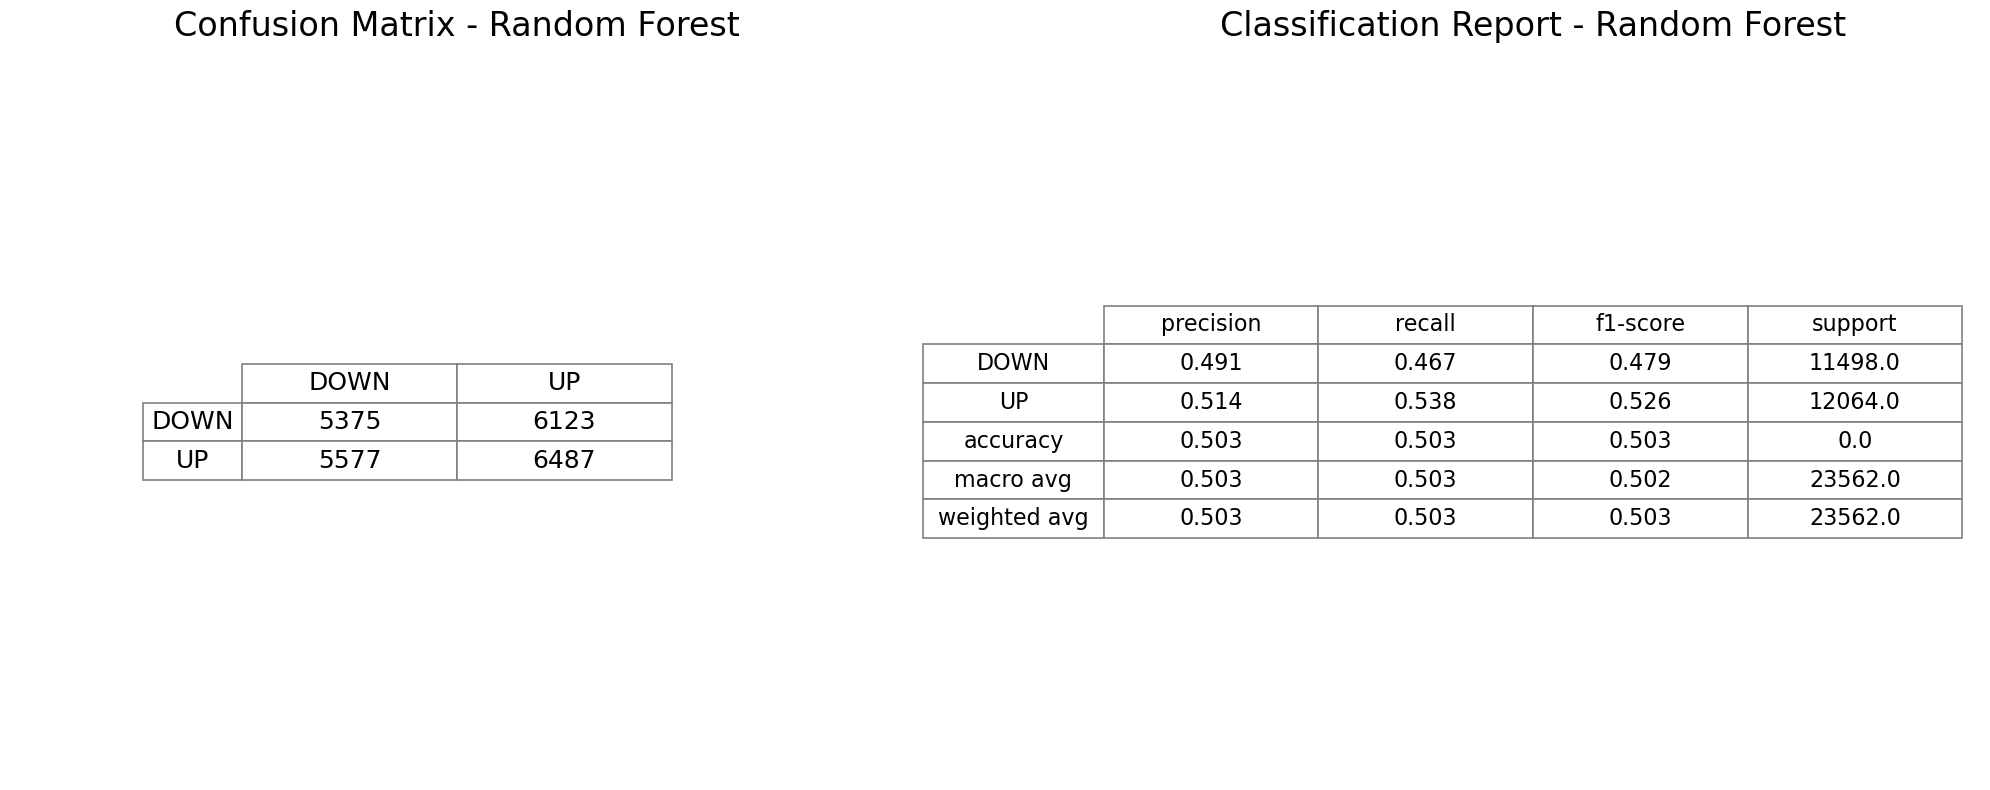

In [110]:
# display validation accuracy
print(f"Validation Accuracy: {rf_acc:.4f}")

# confusion matrix
rf_cm = confusion_matrix(y_val, rf_y_pred)
labels = sorted(merged_1day['target'].unique())
rf_cm_df = pd.DataFrame(rf_cm, index=labels, columns=labels)

# classification report
rf_cr = classification_report(y_val, rf_y_pred, output_dict=True)
rf_cr_df = pd.DataFrame(rf_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    rf_cr_df[col] = rf_cr_df[col].round(3)
rf_cr_df['support'] = rf_cr_df['support'].astype(int)
rf_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=rf_cm_df.values,
                       rowLabels=rf_cm_df.index,
                       colLabels=rf_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(rf_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=rf_cr_df.values,
                       rowLabels=rf_cr_df.index,
                       colLabels=rf_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(rf_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Random Forest', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('rf_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [22]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_val with results
rf_val_results = merged_1day_val.copy()
rf_val_results['prob_up'] = rf_y_proba

# add daily % return column
rf_val_results['daily_return_pct'] = ((rf_val_results['close'] - rf_val_results['prev_close']) / rf_val_results['prev_close']) * 100

# sort by date and predicted probability
rf_sorted_preds = rf_val_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
rf_sorted_preds = rf_sorted_preds[rf_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
rf_top5_daily = rf_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
rf_daily_avg_return = rf_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
rf_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
rf_daily_avg_return['cumulative_return_pct'] = (1 + rf_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
rf_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [23]:
# Build S&P 500 comparison

# get S&P 500 data for the same date range
start_date = rf_daily_avg_return['date'].min()
end_date = rf_daily_avg_return['date'].max()
sp500 = yf.download("^GSPC", start=start_date, end=end_date)

# ensure index is datetime and trimmed to match your data
sp500 = sp500[['Open', 'Close']]
sp500 = sp500.reset_index()  # brings 'Date' into a column
sp500.rename(columns={'Date': 'date'}, inplace=True)  # match column name with daily_avg_return

# prepare the S&P 500 daily % returns and cumulative return
sp500['daily_return_pct'] = ((sp500['Close'] - sp500['Open']) / sp500['Open']) * 100
sp500['sp500_cum_return_pct'] = (1 + sp500['daily_return_pct'] / 100).cumprod() - 1
sp500['sp500_cum_return_pct'] *= 100

# ensure sp500 'date' is datetime type
sp500['date'] = pd.to_datetime(sp500['date'])

# flatten sp500 multi-level columns (if any)
sp500.columns = [col if isinstance(col, str) else col[0] for col in sp500.columns]

# merge with your returns
rf_comparison = rf_daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


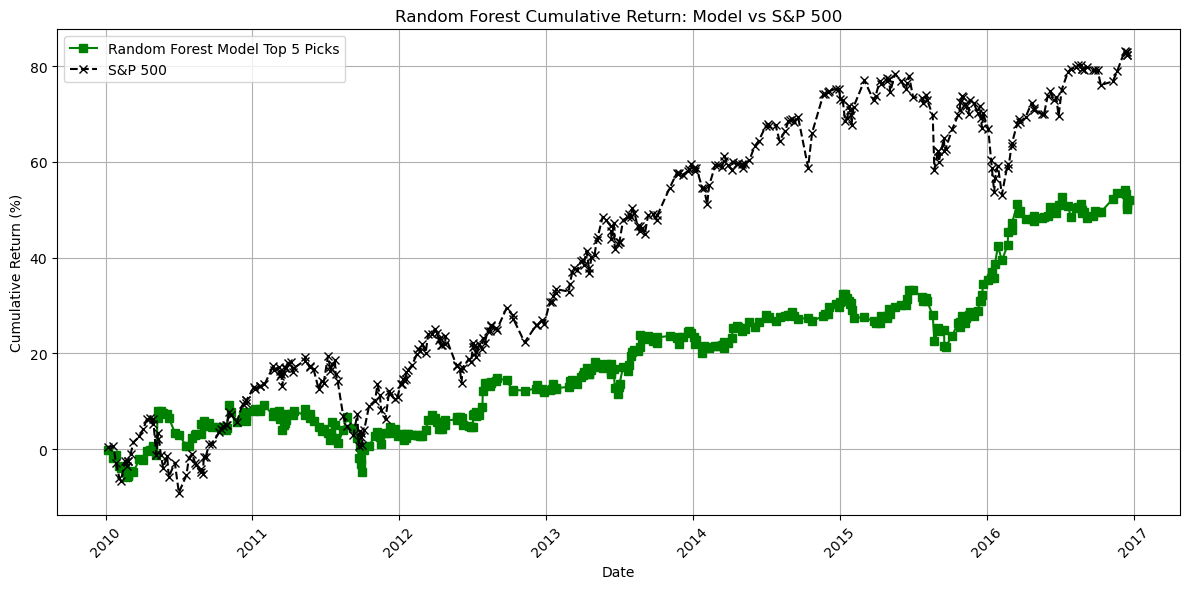

In [90]:
# plot rf model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    rf_comparison['date'], rf_comparison['cumulative_return_pct'],
    label='Random Forest Model Top 5 Picks',
    color='green', marker='s', linestyle='-')
plt.plot(
    rf_comparison['date'], rf_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Random Forest Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('new_rf_cumulative_return_comparison.png', format='png') 
plt.show()

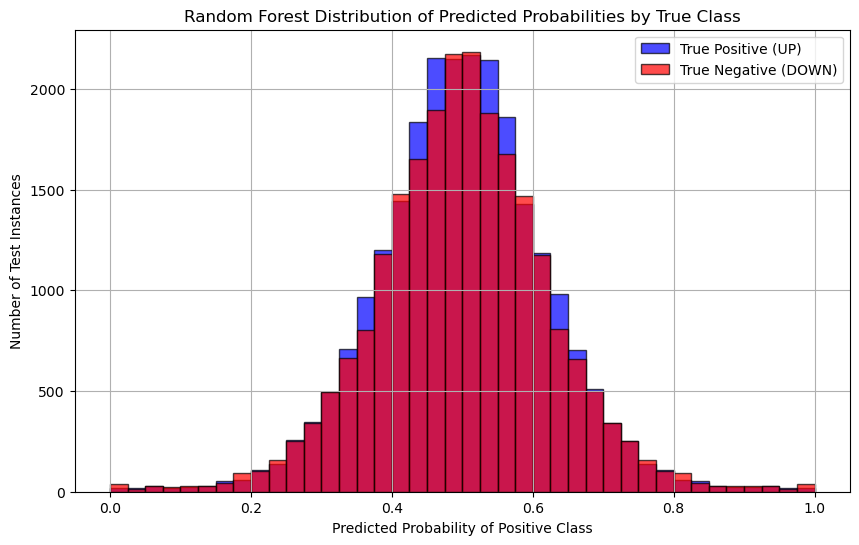

In [91]:
# plot distributions of predictions by true class
y_val_array = np.array(y_val)

# Then split the predicted probabilities based on true labels
probs_positive = rf_probs[y_val_array == 1]
probs_negative = rf_probs[y_val_array == 0]

probs_positive = probs_positive.flatten()
probs_negative = probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Random Forest Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('new_rf_prob_distribution_versus_true_class.png', format='png') 
plt.show()

### Build and Tune Neural Network

In [61]:
# define Keras model builder function
def build_nn_model(hidden_layer_sizes=(128, 64),
                   dropout_rates=(0.6, 0.3),
                   activation='relu',
                   optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(5000,)))
        
    model.add(Dense(hidden_layer_sizes[0], activation=activation))
    model.add(Dropout(dropout_rates[0]))
    
    model.add(Dense(hidden_layer_sizes[1], activation=activation))
    model.add(Dropout(dropout_rates[1]))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [62]:
# build pipeline
nn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('nn', KerasClassifier(model=build_nn_model, verbose=0))
])

# parameter grid
nn_param_grid = {
    'tfidf__max_features': [5000],
    'nn__model__activation': ['relu'],
    'nn__optimizer': ['adam'],
    'nn__batch_size': [32],
    'nn__epochs': [10],
    'nn__model__dropout_rates': [(0.6, 0.3)]
}

# GridSearch
nn_grid = GridSearchCV(
    nn_pipeline, nn_param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=1,
    verbose=3
)

In [63]:
# estimate tuning time
nn_pipeline_clone = clone(nn_pipeline)

start = time.time()
nn_pipeline_clone.fit(X_fold_train, y_fold_train)
_ = nn_pipeline_clone.predict(X_fold_val)
time_per_fold_sample = time.time() - start

correction_factor = 1 / sample_frac
time_per_fold_full = time_per_fold_sample * correction_factor

# estimate total time
n_candidates = len(nn_param_grid) if isinstance(nn_param_grid, list) else np.prod([len(v) for v in nn_param_grid.values()])
n_folds = 5

estimated_total_time = time_per_fold_full * n_candidates * n_folds

print(f"Estimated total GridSearchCV time: {estimated_total_time/60:.2f} minutes (~{estimated_total_time/3600:.2f} hours)")

Estimated total GridSearchCV time: 2.05 minutes (~0.03 hours)


In [64]:
# fit on the training set
start = time.time()
nn_grid.fit(X_train, y_train)
train_time = time.time() - start
print('Time required to tune model (min): {:.1f}'.format(train_time/60))

# best model
print(f"Best RF Parameters: {nn_grid.best_params_}")
print(f"Best RF CV Accuracy: {nn_grid.best_score_:.4f}")

# get the best pipeline
best_nn_model = nn_grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END nn__batch_size=32, nn__epochs=10, nn__model__activation=relu, nn__model__dropout_rates=(0.6, 0.3), nn__optimizer=adam, tfidf__max_features=5000;, score=0.549 total time=  36.9s
[CV 2/5] END nn__batch_size=32, nn__epochs=10, nn__model__activation=relu, nn__model__dropout_rates=(0.6, 0.3), nn__optimizer=adam, tfidf__max_features=5000;, score=0.543 total time=  36.5s
[CV 3/5] END nn__batch_size=32, nn__epochs=10, nn__model__activation=relu, nn__model__dropout_rates=(0.6, 0.3), nn__optimizer=adam, tfidf__max_features=5000;, score=0.548 total time=  36.4s
[CV 4/5] END nn__batch_size=32, nn__epochs=10, nn__model__activation=relu, nn__model__dropout_rates=(0.6, 0.3), nn__optimizer=adam, tfidf__max_features=5000;, score=0.545 total time=  37.7s
[CV 5/5] END nn__batch_size=32, nn__epochs=10, nn__model__activation=relu, nn__model__dropout_rates=(0.6, 0.3), nn__optimizer=adam, tfidf__max_features=5000;, score=0.552 total time

In [65]:
nn_probs = best_nn_model.predict_proba(X_val)
nn_y_proba = nn_probs[:, 1]
nn_y_pred = (nn_y_proba > 0.5).astype("int32")
nn_acc = accuracy_score(y_val, nn_y_pred)

Accuracy: 0.5005

Confusion Matrix:
      DOWN    UP
DOWN  5753  5745
UP    6025  6039

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.49     11498
           1       0.51      0.50      0.51     12064

    accuracy                           0.50     23562
   macro avg       0.50      0.50      0.50     23562
weighted avg       0.50      0.50      0.50     23562



Validation Accuracy: 0.5005


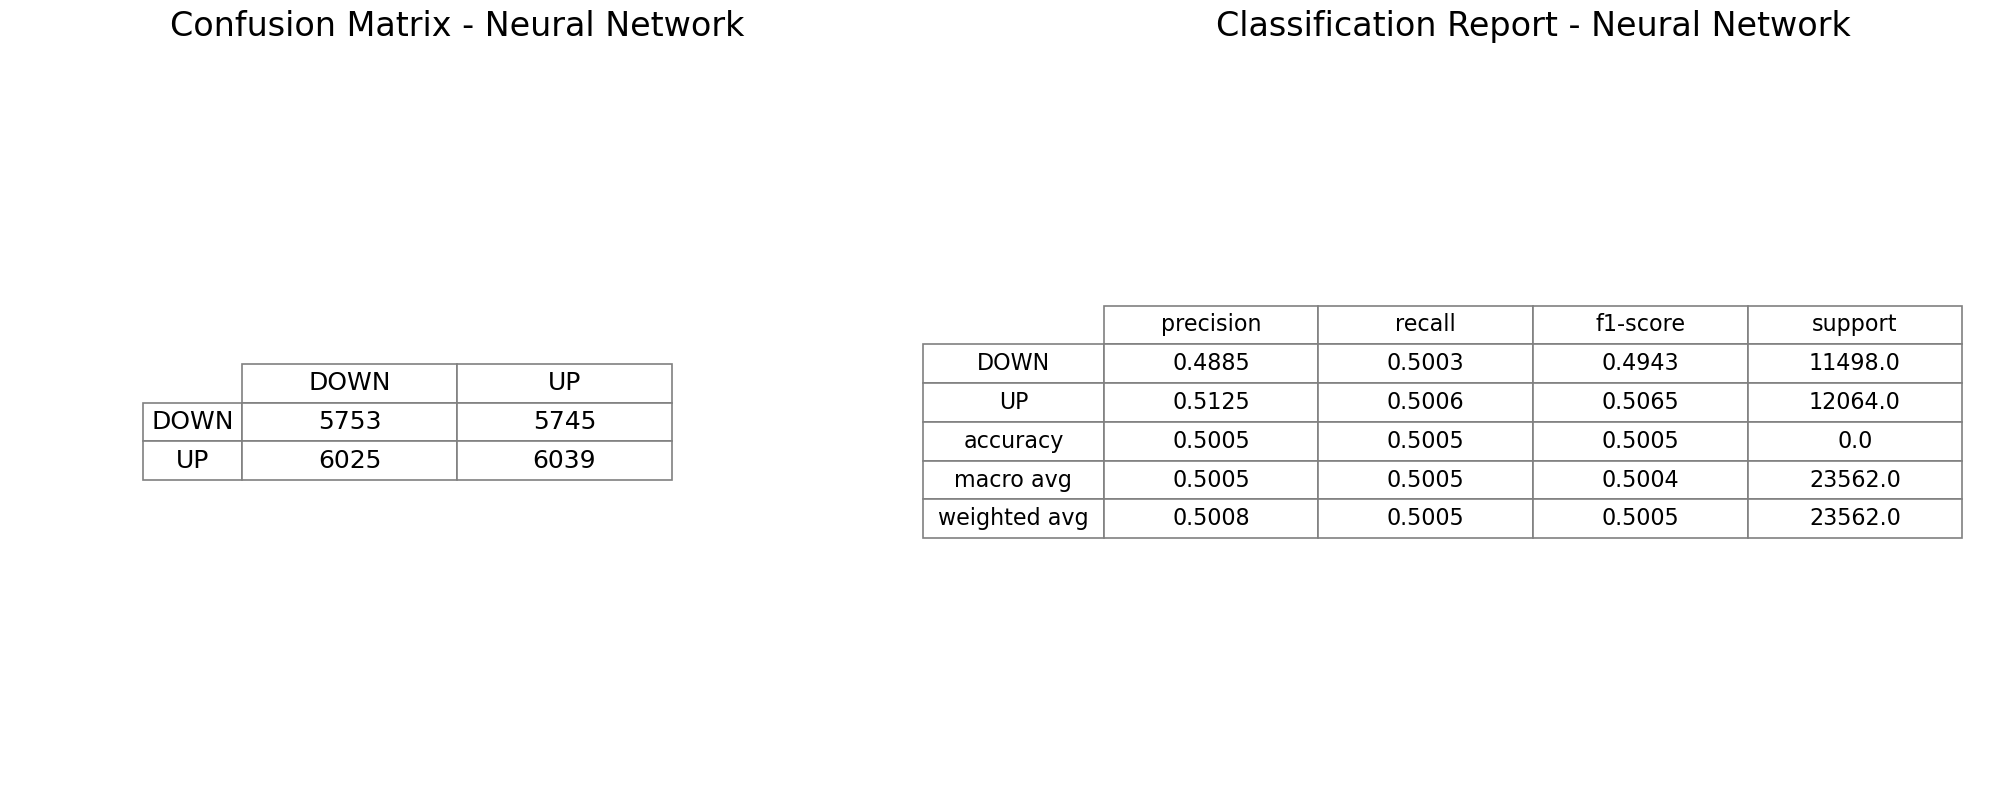

In [113]:
# display validation accuracy
print(f"Validation Accuracy: {nn_acc:.4f}")

# confusion matrix
nn_cm = confusion_matrix(y_val, nn_y_pred)
labels = sorted(merged_1day['target'].unique())
nn_cm_df = pd.DataFrame(nn_cm, index=labels, columns=labels)

# classification report
nn_cr = classification_report(y_val, nn_y_pred, output_dict=True)
nn_cr_df = pd.DataFrame(nn_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    nn_cr_df[col] = nn_cr_df[col].round(4)
nn_cr_df['support'] = nn_cr_df['support'].astype(int)
nn_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=nn_cm_df.values,
                       rowLabels=nn_cm_df.index,
                       colLabels=nn_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(nn_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Neural Network', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=nn_cr_df.values,
                       rowLabels=nn_cr_df.index,
                       colLabels=nn_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(nn_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Neural Network', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('nn_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [66]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_val with results
nn_val_results = merged_1day_val.copy()
nn_val_results['prob_up'] = nn_y_proba

# add daily % return column
nn_val_results['daily_return_pct'] = ((nn_val_results['close'] - nn_val_results['prev_close']) / nn_val_results['prev_close']) * 100

# sort by date and predicted probability
nn_sorted_preds = nn_val_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
nn_sorted_preds = nn_sorted_preds[nn_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
nn_top5_daily = nn_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
nn_daily_avg_return = nn_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
nn_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
nn_daily_avg_return['cumulative_return_pct'] = (1 + nn_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
nn_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [67]:
# merge with model returns
nn_comparison = nn_daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

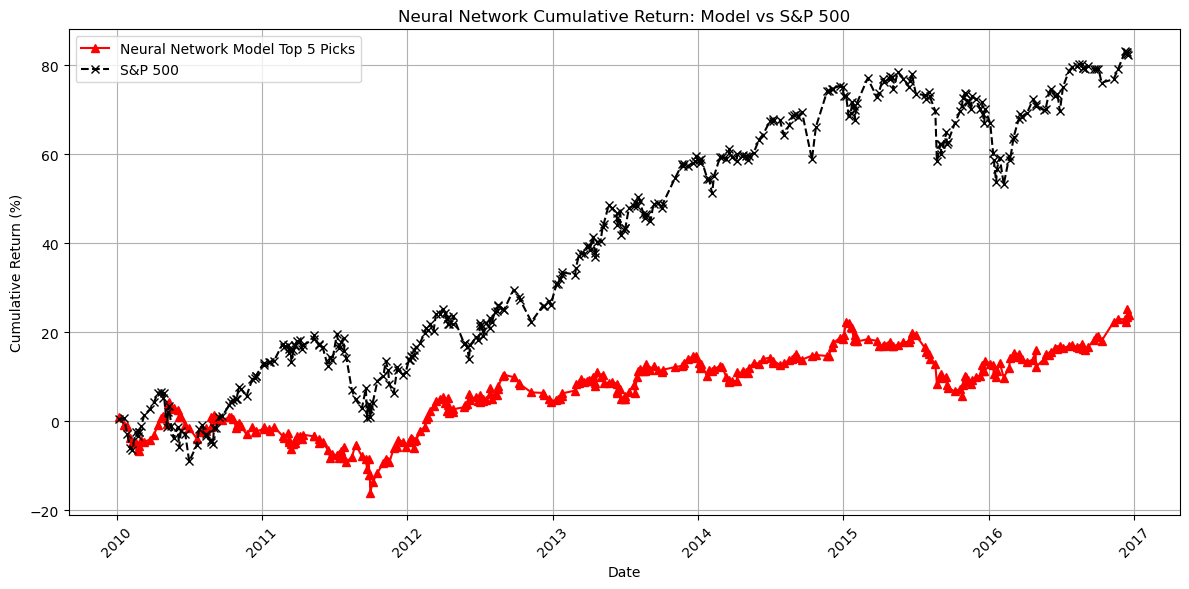

In [92]:
# plot nn model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(nn_comparison['date'], nn_comparison['cumulative_return_pct'],
         label='Neural Network Model Top 5 Picks',
         color='red', marker='^', linestyle='-')
plt.plot(nn_comparison['date'], nn_comparison['sp500_cum_return_pct'],
         label='S&P 500',
         color='black', marker='x', linestyle='--')

plt.title("Neural Network Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('new_nn_cumulative_return_comparison.png', format='png') 
plt.show()

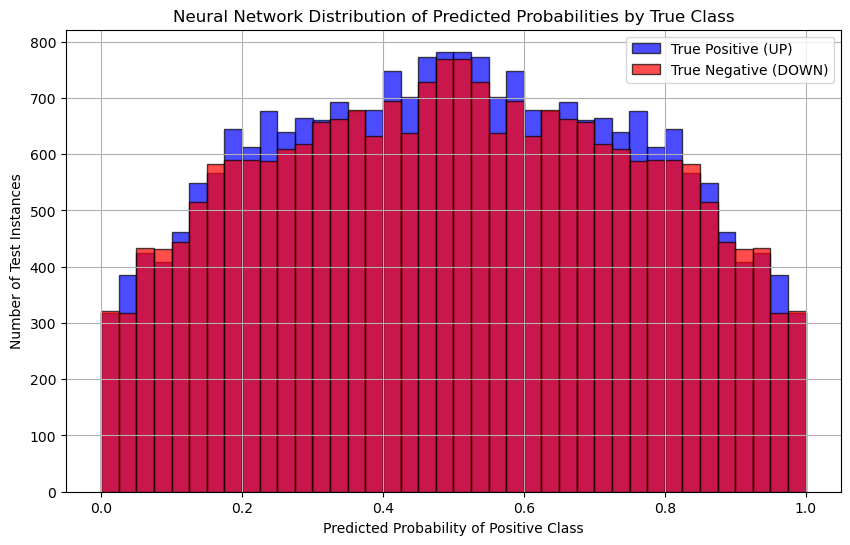

In [93]:
# plot distributions of predictions by true class

# split the predicted probabilities based on true labels
nn_probs_positive = nn_probs[y_val_array == 1]
nn_probs_negative = nn_probs[y_val_array == 0]

nn_probs_positive = nn_probs_positive.flatten()
nn_probs_negative = nn_probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(nn_probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(nn_probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Neural Network Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('new_nn_prob_distribution_versus_true_class.png', format='png') 
plt.show()

## Build and Train Stacked Model with K-fold Stacking

In [73]:
# merge train and val sets
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# prepare base model clones (to avoid leakage)
base_model_1 = clone(best_rf_model)
base_model_2 = clone(best_nn_model)

# initialize out-of-fold prediction arrays
n_folds = 5
oof_preds_rf = np.zeros(len(X_train_full))
oof_preds_nn = np.zeros(len(X_train_full))

# loop through folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"Training fold {fold + 1}/{n_folds}...")
    
    # split data
    X_tr, X_val_fold = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_val_fold = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
    
    # train both base models
    model_rf = clone(base_model_1)
    model_nn = clone(base_model_2)

    model_rf.fit(X_tr, y_tr)
    model_nn.fit(X_tr, y_tr, nn__verbose=0)

    # get validation predictions
    oof_preds_rf[val_idx] = model_rf.predict_proba(X_val_fold)[:, 1]
    oof_preds_nn[val_idx] = model_nn.predict_proba(X_val_fold)[:, 1]

# stack OOF predictions together
stacked_oof_preds = np.column_stack((oof_preds_rf, oof_preds_nn))

# train meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_oof_preds, y_train_full)

Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...


LogisticRegression()

In [74]:
# retrain base models on train+val data
best_rf_model.fit(X_train_full, y_train_full)
best_nn_model.fit(X_train_full, y_train_full, nn__verbose=0)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('nn',
                 KerasClassifier(batch_size=32, epochs=10, model=<function build_nn_model at 0x3617828e0>, model__activation='relu', model__dropout_rates=(0.6, 0.3), optimizer='adam', verbose=0))])

### Evaluate on test data

In [80]:
# get predictions from both models on test set and combine
rf_test_preds = best_rf_model.predict_proba(X_test)[:,1]
nn_test_preds = best_nn_model.predict_proba(X_test)[:,1]
stacked_test_preds = np.column_stack((rf_test_preds, nn_test_preds))

meta_probs = meta_model.predict_proba(stacked_test_preds)
meta_y_proba = meta_probs[:, 1]
meta_y_pred = (meta_y_proba > 0.5).astype("int32")
meta_acc = accuracy_score(y_test, meta_y_pred)

Accuracy: 0.5061

Confusion Matrix:
      DOWN    UP
DOWN  4818  6473
UP    5067  7005

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.43      0.46     11291
           1       0.52      0.58      0.55     12072

    accuracy                           0.51     23363
   macro avg       0.50      0.50      0.50     23363
weighted avg       0.50      0.51      0.50     23363



Validation Accuracy: 0.5061


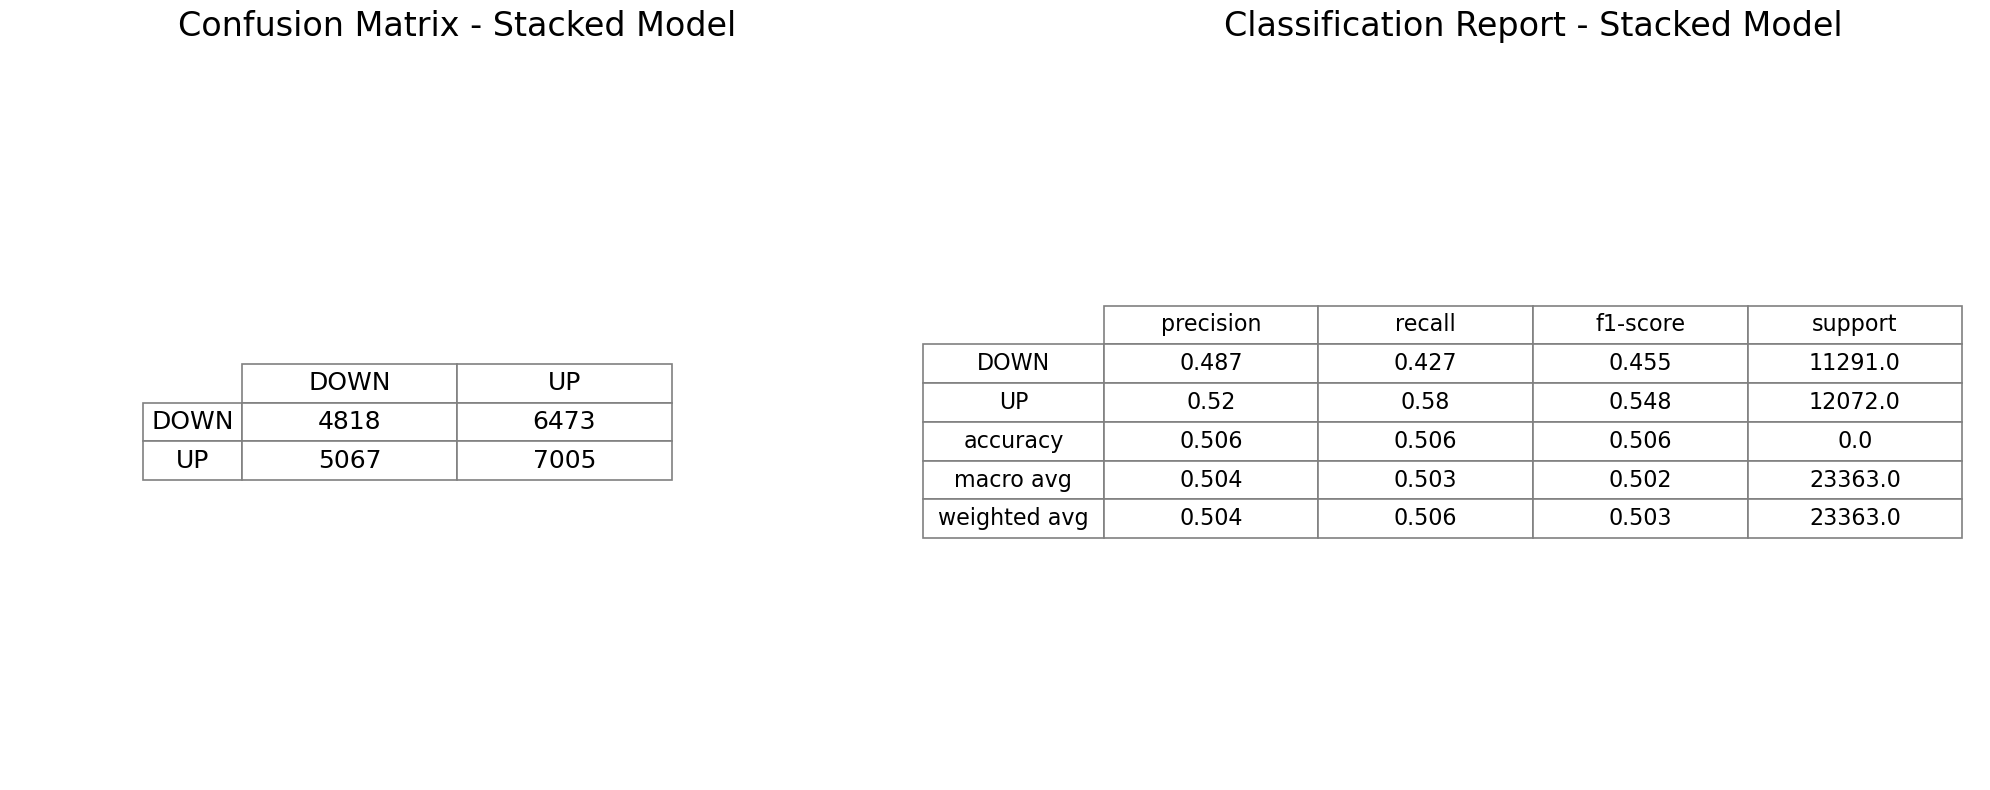

In [117]:
# display validation accuracy
print(f"Validation Accuracy: {meta_acc:.4f}")

# confusion matrix
meta_cm = confusion_matrix(y_test, meta_y_pred)
labels = sorted(merged_1day['target'].unique())
meta_cm_df = pd.DataFrame(meta_cm, index=labels, columns=labels)

# classification report
meta_cr = classification_report(y_test, meta_y_pred, output_dict=True)
meta_cr_df = pd.DataFrame(meta_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    meta_cr_df[col] = meta_cr_df[col].round(3)
meta_cr_df['support'] = meta_cr_df['support'].astype(int)
meta_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=meta_cm_df.values,
                       rowLabels=meta_cm_df.index,
                       colLabels=meta_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(meta_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Stacked Model', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=meta_cr_df.values,
                       rowLabels=meta_cr_df.index,
                       colLabels=meta_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(meta_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Stacked Model', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('meta_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [76]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_test with results
meta_test_results = merged_1day_test.copy()
meta_test_results['prob_up'] = meta_y_proba

# add daily % return column
meta_test_results['daily_return_pct'] = ((meta_test_results['close'] - meta_test_results['prev_close']) / meta_test_results['prev_close']) * 100

# sort by date and predicted probability
meta_sorted_preds = meta_test_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
meta_sorted_preds = meta_sorted_preds[meta_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
meta_top5_daily = meta_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
meta_daily_avg_return = meta_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
meta_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
meta_daily_avg_return['cumulative_return_pct'] = (1 + meta_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
meta_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [78]:
# merge with model returns
meta_comparison = meta_daily_avg_return.merge(
    sp500[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

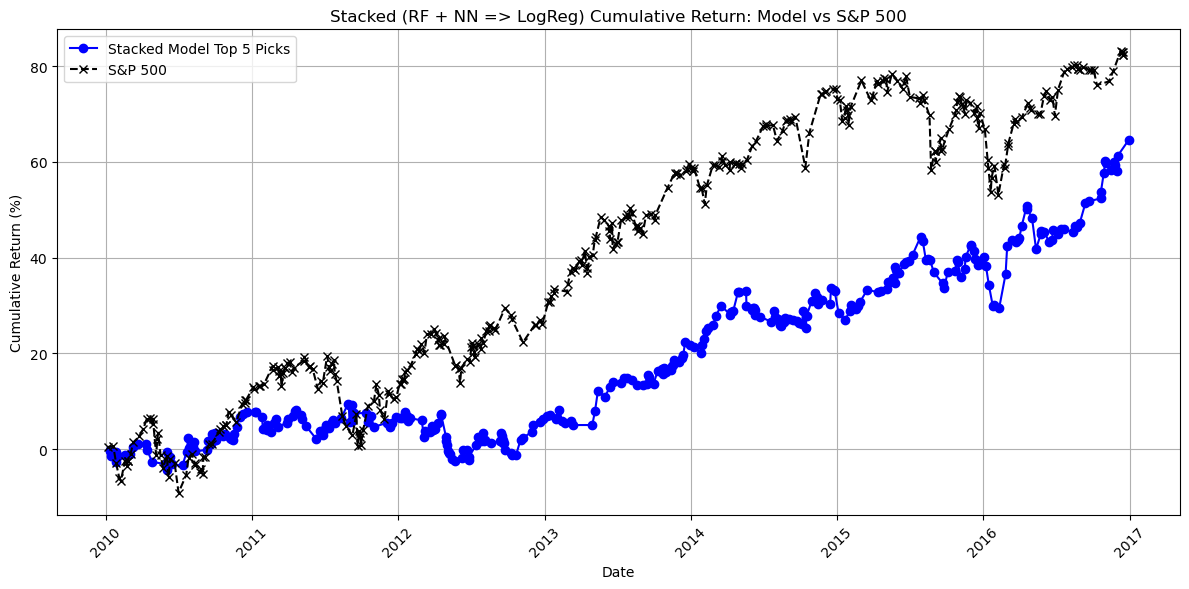

In [94]:
# plot stacked model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    meta_comparison['date'], meta_comparison['cumulative_return_pct'],
    label='Stacked Model Top 5 Picks',
    color='blue', marker='o', linestyle='-')
plt.plot(
    nn_comparison['date'], nn_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Stacked (RF + NN => LogReg) Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('new_meta_cumulative_return_comparison.png', format='png') 
plt.show()

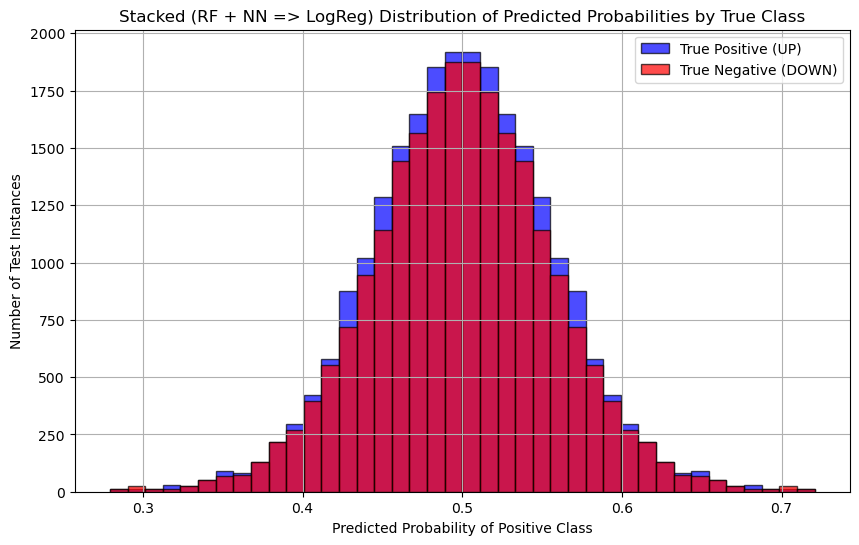

In [95]:
# plot distributions of predictions by true class
y_test_array = np.array(y_test)

# split the predicted probabilities based on true labels
meta_probs_positive = meta_probs[y_test_array == 1]
meta_probs_negative = meta_probs[y_test_array == 0]

meta_probs_positive = meta_probs_positive.flatten()
meta_probs_negative = meta_probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(meta_probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(meta_probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Stacked (RF + NN => LogReg) Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('new_meta_prob_distribution_versus_true_class.png', format='png')
plt.show()

## Summary of Model Performance: Cumulative Returns versus S&P 500

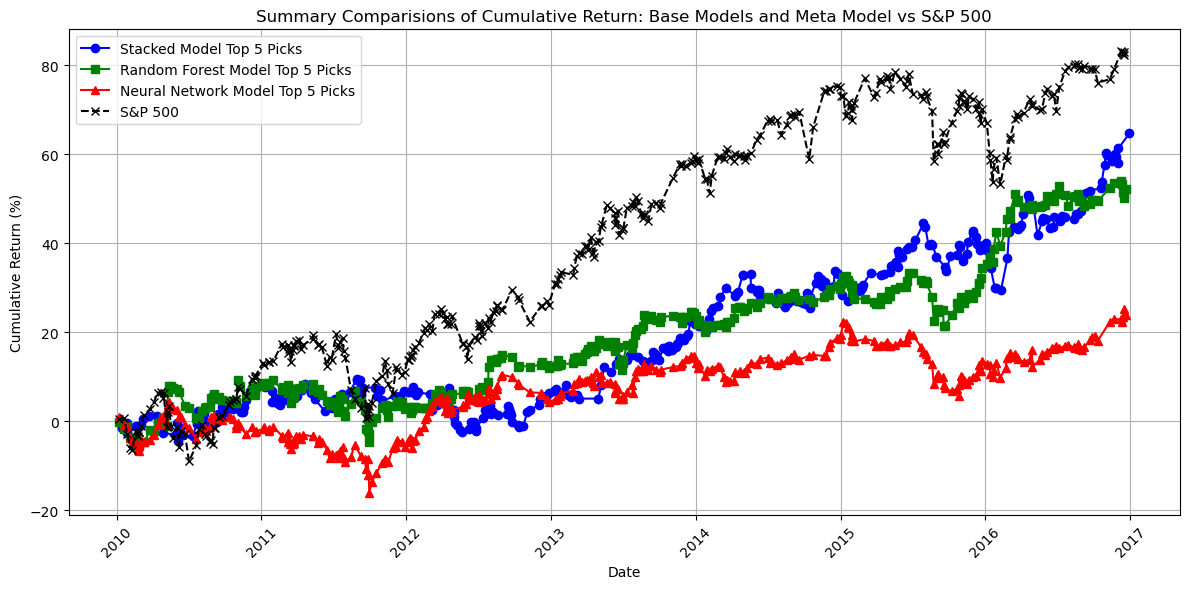

In [96]:
# plot stacked model, RF, and NN returns with S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    meta_comparison['date'], meta_comparison['cumulative_return_pct'],
    label='Stacked Model Top 5 Picks',
    color='blue', marker='o', linestyle='-')
plt.plot(
    rf_comparison['date'], rf_comparison['cumulative_return_pct'],
    label='Random Forest Model Top 5 Picks',
    color='green', marker='s', linestyle='-')
plt.plot(
    nn_comparison['date'], nn_comparison['cumulative_return_pct'],
    label='Neural Network Model Top 5 Picks',
    color='red', marker='^', linestyle='-')
plt.plot(
    nn_comparison['date'], nn_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Summary Comparisions of Cumulative Return: Base Models and Meta Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('new_summary_cumulative_return_comparison.png', format='png') 
plt.show()